## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [3]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [4]:
df_train = pd.read_csv("../../data/train/cardio/cardio_maccs_train.csv")
df_test = pd.read_csv("../../data/train/cardio/cardio_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/cardio/cardio_maccs_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [5]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'pIC50']
y_train_all = df_train_all['pIC50']

X_train = df_train.loc[:, df_train.columns != 'pIC50']
y_train = df_train['pIC50']

X_test = df_test.loc[:, df_test.columns != 'pIC50']
y_test = df_test['pIC50']

X_valid = df_valid.loc[:, df_valid.columns != 'pIC50']
y_valid = df_valid['pIC50']

In [6]:
X_train.shape

(7442, 166)

In [7]:
X_test.shape

(2127, 166)

In [8]:
X_valid.shape

(1063, 166)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [9]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(166, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [10]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [11]:
best_value = 1
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=1063, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 3.3261261508188533, Accuracy: -3.2493332716730174
Test Avg. loss: 2.9344711303710938, Accuracy: -2.4477868397532925
################## EPOCH 2 ##################
Train Avg. loss: 2.4557757157624533, Accuracy: -2.0127351556675515
Test Avg. loss: 1.104469895362854, Accuracy: -0.29767049089584163
################## EPOCH 3 ##################
Train Avg. loss: 2.342633908910301, Accuracy: -1.8659757574321534
Test Avg. loss: 0.9339019656181335, Accuracy: -0.09726590253936873
################## EPOCH 4 ##################
Train Avg. loss: 2.17790815119068, Accuracy: -1.7244786571163055
Test Avg. loss: 1.138991117477417, Accuracy: -0.33823040635851
################## EPOCH 5 ##################
Train Avg. loss: 2.1107554343636967, Accuracy: -1.6107634630381216
Test Avg. loss: 0.8960820436477661, Accuracy: -0.052830258959131404
################## EPOCH 6 ##################
Train Avg. loss: 1.975991310224

Train Avg. loss: 0.4768951965631845, Accuracy: 0.4264685401824652
Test Avg. loss: 0.40869951248168945, Accuracy: 0.5198082578950233
################## EPOCH 48 ##################
Train Avg. loss: 0.47272453294035705, Accuracy: 0.4296970804894212
Test Avg. loss: 0.4080495238304138, Accuracy: 0.520571936763834
################## EPOCH 49 ##################
Train Avg. loss: 0.48167519712652773, Accuracy: 0.42294913400752177
Test Avg. loss: 0.3900810182094574, Accuracy: 0.5416835653226819
################## EPOCH 50 ##################
Train Avg. loss: 0.46534979835856116, Accuracy: 0.4353314001996932
Test Avg. loss: 0.39378970861434937, Accuracy: 0.5373261605956383
################## EPOCH 51 ##################
Train Avg. loss: 0.45517211161202115, Accuracy: 0.4507313525661141
Test Avg. loss: 0.3958882987499237, Accuracy: 0.5348604978449947
################## EPOCH 52 ##################
Train Avg. loss: 0.45769496728933934, Accuracy: 0.44861157451883116
Test Avg. loss: 0.39907050132751465,

Train Avg. loss: 0.36477854656047576, Accuracy: 0.5609673202414305
Test Avg. loss: 0.3842330574989319, Accuracy: 0.5485545246576302
################## EPOCH 94 ##################
Train Avg. loss: 0.35529107677194693, Accuracy: 0.5744003402007093
Test Avg. loss: 0.3771592974662781, Accuracy: 0.5568656518792072
################## EPOCH 95 ##################
Train Avg. loss: 0.35679891309001416, Accuracy: 0.5723646696310786
Test Avg. loss: 0.3832862079143524, Accuracy: 0.5496669599206387
################## EPOCH 96 ##################
Train Avg. loss: 0.3490837827133007, Accuracy: 0.580923685129848
Test Avg. loss: 0.40019750595092773, Accuracy: 0.5297974871427966
################## EPOCH 97 ##################
Train Avg. loss: 0.35792138801623824, Accuracy: 0.5684816060961944
Test Avg. loss: 0.39477330446243286, Accuracy: 0.5361705417410942
################## EPOCH 98 ##################
Train Avg. loss: 0.3524496852392291, Accuracy: 0.5783940782406103
Test Avg. loss: 0.38800060749053955, Ac

Train Avg. loss: 0.3209939752205759, Accuracy: 0.6124589376768758
Test Avg. loss: 0.3921402096748352, Accuracy: 0.5392641752246612
################## EPOCH 140 ##################
Train Avg. loss: 0.32692883668923073, Accuracy: 0.6102013642713918
Test Avg. loss: 0.38454243540763855, Accuracy: 0.5481910406238505
################## EPOCH 141 ##################
Train Avg. loss: 0.3122993300273183, Accuracy: 0.6278677331395134
Test Avg. loss: 0.38529640436172485, Accuracy: 0.5473051949657899
################## EPOCH 142 ##################
Train Avg. loss: 0.3202380093510059, Accuracy: 0.6124892824388634
Test Avg. loss: 0.3914239704608917, Accuracy: 0.5401057371877107
################## EPOCH 143 ##################
Train Avg. loss: 0.31300206616712745, Accuracy: 0.6221891626320806
Test Avg. loss: 0.38078469038009644, Accuracy: 0.5526060897876275
################## EPOCH 144 ##################
Train Avg. loss: 0.31127372380873675, Accuracy: 0.6248906941466738
Test Avg. loss: 0.372961997985839

Train Avg. loss: 0.29115315875270337, Accuracy: 0.64900121033857
Test Avg. loss: 0.3692573308944702, Accuracy: 0.5661498886284348
################## EPOCH 186 ##################
Train Avg. loss: 0.2986208790425579, Accuracy: 0.6427983966604309
Test Avg. loss: 0.39296168088912964, Accuracy: 0.53829906773986
################## EPOCH 187 ##################
Train Avg. loss: 0.29197366481303144, Accuracy: 0.6488901390820209
Test Avg. loss: 0.3707159459590912, Accuracy: 0.5644361439448646
################## EPOCH 188 ##################
Train Avg. loss: 0.29972517311317215, Accuracy: 0.6331732886133535
Test Avg. loss: 0.38547438383102417, Accuracy: 0.5470960281529305
################## EPOCH 189 ##################
Train Avg. loss: 0.29699852925129716, Accuracy: 0.6476591438179115
Test Avg. loss: 0.37540170550346375, Accuracy: 0.5589307329489679
################## EPOCH 190 ##################
Train Avg. loss: 0.2888980941775019, Accuracy: 0.6569660196201224
Test Avg. loss: 0.3754782974720001, 

Train Avg. loss: 0.266493792377828, Accuracy: 0.6803428492794035
Test Avg. loss: 0.38398265838623047, Accuracy: 0.5488487364034493
################## EPOCH 232 ##################
Train Avg. loss: 0.2832141423302147, Accuracy: 0.6591231402915618
Test Avg. loss: 0.36759650707244873, Accuracy: 0.5681012293963947
################## EPOCH 233 ##################
Train Avg. loss: 0.27383859155004114, Accuracy: 0.6695556280186188
Test Avg. loss: 0.3816951811313629, Accuracy: 0.5515363173148713
################## EPOCH 234 ##################
Train Avg. loss: 0.2757479399442673, Accuracy: 0.6675319741381958
Test Avg. loss: 0.3843095004558563, Accuracy: 0.5484647113530124
################## EPOCH 235 ##################
Train Avg. loss: 0.2749429851642494, Accuracy: 0.6735458446714937
Test Avg. loss: 0.3826841115951538, Accuracy: 0.5503744261900649
################## EPOCH 236 ##################
Train Avg. loss: 0.27169362436420413, Accuracy: 0.6723461917994887
Test Avg. loss: 0.3865942060947418, 

Train Avg. loss: 0.26063286884020326, Accuracy: 0.6832719496323987
Test Avg. loss: 0.37994468212127686, Accuracy: 0.5535930596161291
################## EPOCH 278 ##################
Train Avg. loss: 0.2569229565400934, Accuracy: 0.6898204611485637
Test Avg. loss: 0.38556140661239624, Accuracy: 0.5469938301480192
################## EPOCH 279 ##################
Train Avg. loss: 0.2562468162230156, Accuracy: 0.6917288163316764
Test Avg. loss: 0.3846728801727295, Accuracy: 0.5480377640401859
################## EPOCH 280 ##################
Train Avg. loss: 0.2498949660635813, Accuracy: 0.6972944085130226
Test Avg. loss: 0.3797398507595062, Accuracy: 0.5538337175729338
################## EPOCH 281 ##################
Train Avg. loss: 0.24690566851473672, Accuracy: 0.6981300116197946
Test Avg. loss: 0.3775155246257782, Accuracy: 0.5564471531740351
################## EPOCH 282 ##################
Train Avg. loss: 0.2645697440840144, Accuracy: 0.6807768646973662
Test Avg. loss: 0.3865092396736145,

Train Avg. loss: 1.288868743639726, Accuracy: -0.505755766199017
Test Avg. loss: 0.6651273965835571, Accuracy: 0.2185243521179736
################## EPOCH 24 ##################
Train Avg. loss: 1.2267005973392062, Accuracy: -0.4316777116948395
Test Avg. loss: 0.6389443874359131, Accuracy: 0.24928756338027735
################## EPOCH 25 ##################
Train Avg. loss: 1.2246135631178179, Accuracy: -0.4238095670763217
Test Avg. loss: 0.6338678002357483, Accuracy: 0.25525216294169595
################## EPOCH 26 ##################
Train Avg. loss: 1.17695358217272, Accuracy: -0.3545068102871629
Test Avg. loss: 0.6396272778511047, Accuracy: 0.24848513574681963
################## EPOCH 27 ##################
Train Avg. loss: 1.144960230232304, Accuracy: -0.34766093029156453
Test Avg. loss: 0.591322660446167, Accuracy: 0.3052395500288877
################## EPOCH 28 ##################
Train Avg. loss: 1.1610199997567723, Accuracy: -0.3581122292105219
Test Avg. loss: 0.6615781188011169, Accu

Train Avg. loss: 0.513413133784237, Accuracy: 0.41361892664929717
Test Avg. loss: 0.3997921347618103, Accuracy: 0.5302737769374608
################## EPOCH 70 ##################
Train Avg. loss: 0.4995552924198982, Accuracy: 0.43480334554729183
Test Avg. loss: 0.41558706760406494, Accuracy: 0.511715916764407
################## EPOCH 71 ##################
Train Avg. loss: 0.4749077259220629, Accuracy: 0.4514843288641349
Test Avg. loss: 0.4174250662326813, Accuracy: 0.5095563917446254
################## EPOCH 72 ##################
Train Avg. loss: 0.46635506983496183, Accuracy: 0.46716706047720463
Test Avg. loss: 0.42088228464126587, Accuracy: 0.5054943639211327
################## EPOCH 73 ##################
Train Avg. loss: 0.4727570241333073, Accuracy: 0.4574732052565171
Test Avg. loss: 0.43701449036598206, Accuracy: 0.48654025203488604
################## EPOCH 74 ##################
Train Avg. loss: 0.46978850407987577, Accuracy: 0.46182033319955246
Test Avg. loss: 0.38631781935691833,

Train Avg. loss: 0.33000719184294725, Accuracy: 0.6247080024830578
Test Avg. loss: 0.3917955458164215, Accuracy: 0.5396691735414767
################## EPOCH 116 ##################
Train Avg. loss: 0.3419118675156536, Accuracy: 0.6091142757654135
Test Avg. loss: 0.3804379999637604, Accuracy: 0.5530134062906102
################## EPOCH 117 ##################
Train Avg. loss: 0.33076065001834154, Accuracy: 0.6231156297968861
Test Avg. loss: 0.38866734504699707, Accuracy: 0.5433445882553852
################## EPOCH 118 ##################
Train Avg. loss: 0.3362641798125373, Accuracy: 0.6151428865138517
Test Avg. loss: 0.39182817935943604, Accuracy: 0.539630806353228
################## EPOCH 119 ##################
Train Avg. loss: 0.3268389517170751, Accuracy: 0.6228717673135188
Test Avg. loss: 0.3789873421192169, Accuracy: 0.5547178304661076
################## EPOCH 120 ##################
Train Avg. loss: 0.33134713660702747, Accuracy: 0.6231531413946828
Test Avg. loss: 0.387504518032074, 

Train Avg. loss: 0.30585709309730774, Accuracy: 0.6530507651519377
Test Avg. loss: 0.3797489404678345, Accuracy: 0.5538230253427904
################## EPOCH 162 ##################
Train Avg. loss: 0.2893447614887841, Accuracy: 0.6726765842017602
Test Avg. loss: 0.3783511221408844, Accuracy: 0.5554653671161722
################## EPOCH 163 ##################
Train Avg. loss: 0.2786097363529042, Accuracy: 0.6820192729546211
Test Avg. loss: 0.3773278594017029, Accuracy: 0.5566676171926147
################## EPOCH 164 ##################
Train Avg. loss: 0.293180455127333, Accuracy: 0.6690373216636321
Test Avg. loss: 0.38866719603538513, Accuracy: 0.5433447364410995
################## EPOCH 165 ##################
Train Avg. loss: 0.29827398157272583, Accuracy: 0.6582667826351272
Test Avg. loss: 0.3703691363334656, Accuracy: 0.5648436319293171
################## EPOCH 166 ##################
Train Avg. loss: 0.2875039449168576, Accuracy: 0.6722319050672885
Test Avg. loss: 0.39801710844039917, 

Train Avg. loss: 0.27602094781194997, Accuracy: 0.6879218459134246
Test Avg. loss: 0.3911871314048767, Accuracy: 0.5403839684012529
################## EPOCH 208 ##################
Train Avg. loss: 0.27690619357630736, Accuracy: 0.6841609946842854
Test Avg. loss: 0.3813098967075348, Accuracy: 0.5519890095438456
################## EPOCH 209 ##################
Train Avg. loss: 0.27831237311037177, Accuracy: 0.6804160422477062
Test Avg. loss: 0.3797370195388794, Accuracy: 0.5538370035841349
################## EPOCH 210 ##################
Train Avg. loss: 0.2763194337996662, Accuracy: 0.6847176859008455
Test Avg. loss: 0.38055190443992615, Accuracy: 0.5528796201061268
################## EPOCH 211 ##################
Train Avg. loss: 0.26767315613663095, Accuracy: 0.6975750647074093
Test Avg. loss: 0.3734506666660309, Accuracy: 0.561223038710184
################## EPOCH 212 ##################
Train Avg. loss: 0.2655206380618943, Accuracy: 0.696767139014781
Test Avg. loss: 0.3826538026332855, 

Train Avg. loss: 0.25852389136950177, Accuracy: 0.7041670259063325
Test Avg. loss: 0.3753160536289215, Accuracy: 0.5590313428207629
################## EPOCH 254 ##################
Train Avg. loss: 0.2604699862691072, Accuracy: 0.7014853865789805
Test Avg. loss: 0.38709965348243713, Accuracy: 0.5451864814749731
################## EPOCH 255 ##################
Train Avg. loss: 0.2537014396526875, Accuracy: 0.707642838958596
Test Avg. loss: 0.38255271315574646, Accuracy: 0.5505288260706902
################## EPOCH 256 ##################
Train Avg. loss: 0.26248011489709216, Accuracy: 0.7009947257433032
Test Avg. loss: 0.37692323327064514, Accuracy: 0.5571430168002378
################## EPOCH 257 ##################
Train Avg. loss: 0.24944990548567894, Accuracy: 0.717545820088855
Test Avg. loss: 0.38141822814941406, Accuracy: 0.5518617466754407
################## EPOCH 258 ##################
Train Avg. loss: 0.2556137212066569, Accuracy: 0.7072940253344328
Test Avg. loss: 0.3820180594921112

Train Avg. loss: 0.24562197611627415, Accuracy: 0.7199442641742105
Test Avg. loss: 0.37414243817329407, Accuracy: 0.5604102747784556
################## EPOCH 300 ##################
Train Avg. loss: 0.24955427710317138, Accuracy: 0.7146145130718007
Test Avg. loss: 0.3821088969707489, Accuracy: 0.5510502511521611
Model: lr 0.001, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 4.291421593245813, Accuracy: -3.983492998296885
Test Avg. loss: 3.2048416137695312, Accuracy: -2.7654524782365004
################## EPOCH 2 ##################
Train Avg. loss: 2.109779947895115, Accuracy: -1.4228735033847364
Test Avg. loss: 2.24180269241333, Accuracy: -1.6339527634182969
################## EPOCH 3 ##################
Train Avg. loss: 2.112300236346358, Accuracy: -1.4328809335067372
Test Avg. loss: 2.0704026222229004, Accuracy: -1.4325700513964872
################## EPOCH 4 ##################
Train Avg. loss: 2.1166443077184387, Accuracy: -1.4469712442724103
Test Avg. l

Train Avg. loss: 1.133103716171394, Accuracy: -0.2981288543681016
Test Avg. loss: 0.5621978640556335, Accuracy: 0.33945900397655315
################## EPOCH 46 ##################
Train Avg. loss: 1.0952252068762052, Accuracy: -0.2638299219890871
Test Avg. loss: 0.6086937785148621, Accuracy: 0.28482971743804597
################## EPOCH 47 ##################
Train Avg. loss: 1.1063876424805592, Accuracy: -0.26101291264989124
Test Avg. loss: 0.5667805075645447, Accuracy: 0.33407476111413037
################## EPOCH 48 ##################
Train Avg. loss: 1.0572846541970462, Accuracy: -0.20843624121850124
Test Avg. loss: 0.5718880891799927, Accuracy: 0.32807373659520067
################## EPOCH 49 ##################
Train Avg. loss: 1.0681019304162365, Accuracy: -0.23196821973747914
Test Avg. loss: 0.6136878728866577, Accuracy: 0.2789620097185349
################## EPOCH 50 ##################
Train Avg. loss: 1.0563125292123374, Accuracy: -0.1950092334746852
Test Avg. loss: 0.56512171030044

Train Avg. loss: 0.5955218824289613, Accuracy: 0.325729407289107
Test Avg. loss: 0.4537338316440582, Accuracy: 0.46689622870614367
################## EPOCH 92 ##################
Train Avg. loss: 0.5860931777347953, Accuracy: 0.3250782013784325
Test Avg. loss: 0.43543359637260437, Accuracy: 0.48839770477039857
################## EPOCH 93 ##################
Train Avg. loss: 0.5771415296752574, Accuracy: 0.3475618084331444
Test Avg. loss: 0.448788583278656, Accuracy: 0.4727065690118484
################## EPOCH 94 ##################
Train Avg. loss: 0.5655160796339229, Accuracy: 0.3636704531212493
Test Avg. loss: 0.4364158809185028, Accuracy: 0.4872435216427402
################## EPOCH 95 ##################
Train Avg. loss: 0.5428381041955139, Accuracy: 0.3836817071619801
Test Avg. loss: 0.4238000214099884, Accuracy: 0.5020662685033641
################## EPOCH 96 ##################
Train Avg. loss: 0.550092055130813, Accuracy: 0.3683734312453377
Test Avg. loss: 0.4126701056957245, Accuracy

Train Avg. loss: 0.3764349386348563, Accuracy: 0.57985884731557
Test Avg. loss: 0.38740983605384827, Accuracy: 0.5448220642779368
################## EPOCH 138 ##################
Train Avg. loss: 0.3706643184867956, Accuracy: 0.5777798790566616
Test Avg. loss: 0.3876037299633026, Accuracy: 0.5445942510347057
################## EPOCH 139 ##################
Train Avg. loss: 0.36144767297526537, Accuracy: 0.5949601730636143
Test Avg. loss: 0.40435245633125305, Accuracy: 0.5249156947639181
################## EPOCH 140 ##################
Train Avg. loss: 0.3636053690718392, Accuracy: 0.593621786330365
Test Avg. loss: 0.3873312175273895, Accuracy: 0.5449144168886222
################## EPOCH 141 ##################
Train Avg. loss: 0.3599953876208451, Accuracy: 0.5987534432907748
Test Avg. loss: 0.3954940438270569, Accuracy: 0.5353236523704988
################## EPOCH 142 ##################
Train Avg. loss: 0.3606722809500613, Accuracy: 0.5932391979080605
Test Avg. loss: 0.392002671957016, Accu

Train Avg. loss: 0.2907627847487644, Accuracy: 0.6720447437380808
Test Avg. loss: 0.371072381734848, Accuracy: 0.5640173275720763
################## EPOCH 184 ##################
Train Avg. loss: 0.29457939252004783, Accuracy: 0.6722716622801435
Test Avg. loss: 0.36115190386772156, Accuracy: 0.5756731768509806
################## EPOCH 185 ##################
Train Avg. loss: 0.2910928872682281, Accuracy: 0.6748148393706335
Test Avg. loss: 0.3723355829715729, Accuracy: 0.5625331578074744
################## EPOCH 186 ##################
Train Avg. loss: 0.2930994884947599, Accuracy: 0.6635491772614512
Test Avg. loss: 0.3592643439769745, Accuracy: 0.5778908911391183
################## EPOCH 187 ##################
Train Avg. loss: 0.3032878079151703, Accuracy: 0.6585265023772366
Test Avg. loss: 0.37797850370407104, Accuracy: 0.5559031433039445
################## EPOCH 188 ##################
Train Avg. loss: 0.29162357128777744, Accuracy: 0.6752342872722035
Test Avg. loss: 0.3677976727485657, 

Train Avg. loss: 0.26882911694504447, Accuracy: 0.7006104140208659
Test Avg. loss: 0.3781222701072693, Accuracy: 0.5557342549444442
################## EPOCH 230 ##################
Train Avg. loss: 0.2726209401074102, Accuracy: 0.6906830836038695
Test Avg. loss: 0.36345022916793823, Accuracy: 0.5729728315644907
################## EPOCH 231 ##################
Train Avg. loss: 0.27063647348244313, Accuracy: 0.6971118287626304
Test Avg. loss: 0.3715114891529083, Accuracy: 0.5635014223264947
################## EPOCH 232 ##################
Train Avg. loss: 0.26519919212086723, Accuracy: 0.7046823729550197
Test Avg. loss: 0.3816829025745392, Accuracy: 0.5515507622651421
################## EPOCH 233 ##################
Train Avg. loss: 0.26537146772873604, Accuracy: 0.7042963930296867
Test Avg. loss: 0.3684248626232147, Accuracy: 0.5671279887611467
################## EPOCH 234 ##################
Train Avg. loss: 0.26434384791527765, Accuracy: 0.7025025151176725
Test Avg. loss: 0.371836245059967

Train Avg. loss: 0.2565119536751408, Accuracy: 0.7129759305280964
Test Avg. loss: 0.3642905056476593, Accuracy: 0.5719855404685896
################## EPOCH 276 ##################
Train Avg. loss: 0.2504763699815435, Accuracy: 0.7197255430979781
Test Avg. loss: 0.36971065402030945, Accuracy: 0.5656172580857934
################## EPOCH 277 ##################
Train Avg. loss: 0.2598727784924588, Accuracy: 0.7036345320147873
Test Avg. loss: 0.3605051338672638, Accuracy: 0.576433103572158
################## EPOCH 278 ##################
Train Avg. loss: 0.25718716569876265, Accuracy: 0.7121349323129172
Test Avg. loss: 0.36780205368995667, Accuracy: 0.5678597085465554
################## EPOCH 279 ##################
Train Avg. loss: 0.24476856738328934, Accuracy: 0.7248202883879172
Test Avg. loss: 0.3773896396160126, Accuracy: 0.5565950197237525
################## EPOCH 280 ##################
Train Avg. loss: 0.2506571141213684, Accuracy: 0.7174806012030069
Test Avg. loss: 0.3634268045425415, 

Train Avg. loss: 1.925879923502604, Accuracy: -1.2857886101674747
Test Avg. loss: 2.053844451904297, Accuracy: -1.413115641592538
################## EPOCH 22 ##################
Train Avg. loss: 1.909217651685079, Accuracy: -1.1968930101569286
Test Avg. loss: 1.7683415412902832, Accuracy: -1.0776707329252915
################## EPOCH 23 ##################
Train Avg. loss: 1.926212978363037, Accuracy: -1.2815367231414767
Test Avg. loss: 1.7591488361358643, Accuracy: -1.0668699880744588
################## EPOCH 24 ##################
Train Avg. loss: 1.889804971218109, Accuracy: -1.3318454917485159
Test Avg. loss: 1.1223117113113403, Accuracy: -0.3186334367975334
################## EPOCH 25 ##################
Train Avg. loss: 1.9530536214510599, Accuracy: -1.3474982003981875
Test Avg. loss: 2.0519299507141113, Accuracy: -1.4108662344520058
################## EPOCH 26 ##################
Train Avg. loss: 1.8769256711006164, Accuracy: -1.2080615739112475
Test Avg. loss: 1.4644840955734253, Acc

Train Avg. loss: 1.328383775552114, Accuracy: -0.5704227551198343
Test Avg. loss: 0.8338825702667236, Accuracy: 0.0202495084869454
################## EPOCH 68 ##################
Train Avg. loss: 1.3089471201101939, Accuracy: -0.5339909774240759
Test Avg. loss: 0.9719159007072449, Accuracy: -0.14192942909207984
################## EPOCH 69 ##################
Train Avg. loss: 1.3108699361483256, Accuracy: -0.5214998554168492
Test Avg. loss: 0.7524958252906799, Accuracy: 0.11587298793364087
################## EPOCH 70 ##################
Train Avg. loss: 1.3173468867937723, Accuracy: -0.5555948132936592
Test Avg. loss: 0.9229220747947693, Accuracy: -0.08436526083628526
################## EPOCH 71 ##################
Train Avg. loss: 1.3117911756038665, Accuracy: -0.5564562877948268
Test Avg. loss: 0.7586961388587952, Accuracy: 0.10858804818000056
################## EPOCH 72 ##################
Train Avg. loss: 1.2772159536679586, Accuracy: -0.49679996015992095
Test Avg. loss: 0.88208335638046

Train Avg. loss: 0.8848495920499165, Accuracy: -0.014670312825125754
Test Avg. loss: 0.5740723013877869, Accuracy: 0.32550742068453575
################## EPOCH 114 ##################
Train Avg. loss: 0.9248333096504211, Accuracy: -0.1348008828529699
Test Avg. loss: 0.5375649929046631, Accuracy: 0.3684008580187724
################## EPOCH 115 ##################
Train Avg. loss: 0.8926172773043315, Accuracy: -0.06296842408328765
Test Avg. loss: 0.6036537289619446, Accuracy: 0.29075146826797427
################## EPOCH 116 ##################
Train Avg. loss: 0.8832280496756236, Accuracy: -0.03917022924400217
Test Avg. loss: 0.5828178524971008, Accuracy: 0.31523200354956193
################## EPOCH 117 ##################
Train Avg. loss: 0.8594307025273641, Accuracy: -0.004326593539324393
Test Avg. loss: 0.7031900882720947, Accuracy: 0.17380354187393054
################## EPOCH 118 ##################
Train Avg. loss: 0.8729649484157562, Accuracy: -0.046244409251038815
Test Avg. loss: 0.610

Train Avg. loss: 0.5813656310240428, Accuracy: 0.33976172059979887
Test Avg. loss: 0.4644763469696045, Accuracy: 0.454274553458238
################## EPOCH 160 ##################
Train Avg. loss: 0.617293335000674, Accuracy: 0.29043498446723137
Test Avg. loss: 0.5088253617286682, Accuracy: 0.40216785614652173
################## EPOCH 161 ##################
Train Avg. loss: 0.6231272707382838, Accuracy: 0.2942393611876973
Test Avg. loss: 0.4759136140346527, Accuracy: 0.4408366430279127
################## EPOCH 162 ##################
Train Avg. loss: 0.6139512499173482, Accuracy: 0.28902616175294715
Test Avg. loss: 0.48131051659584045, Accuracy: 0.4344956608406928
################## EPOCH 163 ##################
Train Avg. loss: 0.6081892122824987, Accuracy: 0.27259243308546577
Test Avg. loss: 0.4602985084056854, Accuracy: 0.4591832146521211
################## EPOCH 164 ##################
Train Avg. loss: 0.5763225888212522, Accuracy: 0.34222895562700223
Test Avg. loss: 0.48946613073349, 

Train Avg. loss: 0.43130652358134586, Accuracy: 0.500522647785393
Test Avg. loss: 0.39111512899398804, Accuracy: 0.5404686078970438
################## EPOCH 206 ##################
Train Avg. loss: 0.41065690567096075, Accuracy: 0.5295107362312163
Test Avg. loss: 0.40793028473854065, Accuracy: 0.5207120584397045
################## EPOCH 207 ##################
Train Avg. loss: 0.4254094551006953, Accuracy: 0.510904117539805
Test Avg. loss: 0.41169866919517517, Accuracy: 0.5162844741777973
################## EPOCH 208 ##################
Train Avg. loss: 0.40129924764235814, Accuracy: 0.5411655390065174
Test Avg. loss: 0.3812260031700134, Accuracy: 0.5520875790386077
################## EPOCH 209 ##################
Train Avg. loss: 0.40570944199959436, Accuracy: 0.5314008773003267
Test Avg. loss: 0.40491175651550293, Accuracy: 0.5242585998702786
################## EPOCH 210 ##################
Train Avg. loss: 0.40263186941544216, Accuracy: 0.5410440788627119
Test Avg. loss: 0.38403698801994

Test Avg. loss: 0.39031121134757996, Accuracy: 0.5414131169672743
################## EPOCH 252 ##################
Train Avg. loss: 0.31242560868461927, Accuracy: 0.6512181968731622
Test Avg. loss: 0.39233633875846863, Accuracy: 0.5390337370589795
################## EPOCH 253 ##################
Train Avg. loss: 0.31215938553214073, Accuracy: 0.6482071117289689
Test Avg. loss: 0.3784135580062866, Accuracy: 0.5553920213051537
################## EPOCH 254 ##################
Train Avg. loss: 0.3150822803378105, Accuracy: 0.6315891523970228
Test Avg. loss: 0.39784830808639526, Accuracy: 0.5325576089385691
################## EPOCH 255 ##################
Train Avg. loss: 0.30397714078426363, Accuracy: 0.650364230659583
Test Avg. loss: 0.384186714887619, Accuracy: 0.5486090081844527
################## EPOCH 256 ##################
Train Avg. loss: 0.30731840853889786, Accuracy: 0.6495402186211569
Test Avg. loss: 0.39580804109573364, Accuracy: 0.5349547861776487
################## EPOCH 257 #####

Train Avg. loss: 0.26437146713336307, Accuracy: 0.6959053313807785
Test Avg. loss: 0.39873096346855164, Accuracy: 0.5315205784977652
################## EPOCH 299 ##################
Train Avg. loss: 0.26339597105979917, Accuracy: 0.7066721111347187
Test Avg. loss: 0.4061444103717804, Accuracy: 0.5228103036201928
################## EPOCH 300 ##################
Train Avg. loss: 0.26789580335219704, Accuracy: 0.6997428402603398
Test Avg. loss: 0.40856337547302246, Accuracy: 0.5199681866613727
Model: lr 0.005, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 3.587557555779879, Accuracy: -3.4505671801074893
Test Avg. loss: 1.096764087677002, Accuracy: -0.28861673061702775
################## EPOCH 2 ##################
Train Avg. loss: 2.360854837515835, Accuracy: -1.9523137443618206
Test Avg. loss: 2.671895742416382, Accuracy: -2.1392801559403005
################## EPOCH 3 ##################
Train Avg. loss: 1.9140693043946198, Accuracy: -1.3373930299612256
Test Av

Train Avg. loss: 0.5831126190178384, Accuracy: 0.320717865440411
Test Avg. loss: 0.5296965837478638, Accuracy: 0.3776455856315356
################## EPOCH 45 ##################
Train Avg. loss: 0.5662793296473221, Accuracy: 0.3397363789549812
Test Avg. loss: 0.5048744678497314, Accuracy: 0.4068097788683467
################## EPOCH 46 ##################
Train Avg. loss: 0.5697507612055464, Accuracy: 0.3321758749007068
Test Avg. loss: 0.49865952134132385, Accuracy: 0.41411192202856417
################## EPOCH 47 ##################
Train Avg. loss: 0.5889237429706835, Accuracy: 0.30794268588995594
Test Avg. loss: 0.5165714621543884, Accuracy: 0.3930666901975979
################## EPOCH 48 ##################
Train Avg. loss: 0.5647833503367051, Accuracy: 0.3337821809212187
Test Avg. loss: 0.488994836807251, Accuracy: 0.4254671916697136
################## EPOCH 49 ##################
Train Avg. loss: 0.5472384691238403, Accuracy: 0.3546849925694979
Test Avg. loss: 0.4807285666465759, Accurac

Train Avg. loss: 0.5101057008036728, Accuracy: 0.39522261375562345
Test Avg. loss: 0.46423226594924927, Accuracy: 0.45456137665355667
################## EPOCH 91 ##################
Train Avg. loss: 0.521150565902051, Accuracy: 0.3792351994591201
Test Avg. loss: 0.4753808379173279, Accuracy: 0.4414626369285928
################## EPOCH 92 ##################
Train Avg. loss: 0.5326732035742298, Accuracy: 0.3747800524219707
Test Avg. loss: 0.47307440638542175, Accuracy: 0.4441724669088932
################## EPOCH 93 ##################
Train Avg. loss: 0.5217818035844058, Accuracy: 0.38512372117577115
Test Avg. loss: 0.452217698097229, Accuracy: 0.46867758414881455
################## EPOCH 94 ##################
Train Avg. loss: 0.5078040465648593, Accuracy: 0.4009712960982446
Test Avg. loss: 0.4794488251209259, Accuracy: 0.43668302964117645
################## EPOCH 95 ##################
Train Avg. loss: 0.5133243317639878, Accuracy: 0.39631499169705814
Test Avg. loss: 0.46275001764297485, A

Train Avg. loss: 0.4989761676911121, Accuracy: 0.4119269269528291
Test Avg. loss: 0.4608091711997986, Accuracy: 0.45858324581016874
################## EPOCH 137 ##################
Train Avg. loss: 0.5008420343051141, Accuracy: 0.4084866110202862
Test Avg. loss: 0.47578269243240356, Accuracy: 0.4409904398665597
################## EPOCH 138 ##################
Train Avg. loss: 0.48763115409873586, Accuracy: 0.4236901661059999
Test Avg. loss: 0.4713093340396881, Accuracy: 0.44624630595712045
################## EPOCH 139 ##################
Train Avg. loss: 0.5000085581909434, Accuracy: 0.41138186750075006
Test Avg. loss: 0.47772595286369324, Accuracy: 0.4387072765689053
################## EPOCH 140 ##################
Train Avg. loss: 0.5130611575596322, Accuracy: 0.39517900171268294
Test Avg. loss: 0.47102808952331543, Accuracy: 0.446576762852528
################## EPOCH 141 ##################
Train Avg. loss: 0.5110316369282841, Accuracy: 0.3971502535386692
Test Avg. loss: 0.48196712136268

Train Avg. loss: 0.49304683289046963, Accuracy: 0.4212499093385778
Test Avg. loss: 0.46770942211151123, Accuracy: 0.4504759894736896
################## EPOCH 183 ##################
Train Avg. loss: 0.4759007806174233, Accuracy: 0.4356928829825776
Test Avg. loss: 0.45403167605400085, Accuracy: 0.4665462667462562
################## EPOCH 184 ##################
Train Avg. loss: 0.4971487707590341, Accuracy: 0.4136270196521421
Test Avg. loss: 0.4420466721057892, Accuracy: 0.48062778129478945
################## EPOCH 185 ##################
Train Avg. loss: 0.4887796402489167, Accuracy: 0.42518007251770806
Test Avg. loss: 0.4684751033782959, Accuracy: 0.44957633422713583
################## EPOCH 186 ##################
Train Avg. loss: 0.4782863873268913, Accuracy: 0.4344162491548711
Test Avg. loss: 0.45759332180023193, Accuracy: 0.46236164448278005
################## EPOCH 187 ##################
Train Avg. loss: 0.48153987008870414, Accuracy: 0.4253430402322377
Test Avg. loss: 0.447378933429

Train Avg. loss: 0.47502430141483765, Accuracy: 0.44095397336537473
Test Avg. loss: 0.4589751362800598, Accuracy: 0.46073809630638285
################## EPOCH 229 ##################
Train Avg. loss: 0.4783830678514145, Accuracy: 0.43091413731507167
Test Avg. loss: 0.4595402479171753, Accuracy: 0.4600741300750675
################## EPOCH 230 ##################
Train Avg. loss: 0.45860229042466616, Accuracy: 0.45802726479736433
Test Avg. loss: 0.4648604094982147, Accuracy: 0.45382333615943615
################## EPOCH 231 ##################
Train Avg. loss: 0.46967528120898383, Accuracy: 0.44028978813229025
Test Avg. loss: 0.49811261892318726, Accuracy: 0.4147544682575016
################## EPOCH 232 ##################
Train Avg. loss: 0.4731922468786076, Accuracy: 0.44525758676401694
Test Avg. loss: 0.4632098972797394, Accuracy: 0.45576256177875296
################## EPOCH 233 ##################
Train Avg. loss: 0.45851367628881345, Accuracy: 0.45009735074862317
Test Avg. loss: 0.4506915

Train Avg. loss: 0.45732670581136137, Accuracy: 0.4583530918849944
Test Avg. loss: 0.46281760931015015, Accuracy: 0.4562234813196163
################## EPOCH 275 ##################
Train Avg. loss: 0.44036693065207405, Accuracy: 0.4767749392086428
Test Avg. loss: 0.4630489647388458, Accuracy: 0.4559516412601192
################## EPOCH 276 ##################
Train Avg. loss: 0.4563169458905003, Accuracy: 0.4580004283707335
Test Avg. loss: 0.4737597107887268, Accuracy: 0.44336729230780725
################## EPOCH 277 ##################
Train Avg. loss: 0.4529487785479541, Accuracy: 0.46481915101191623
Test Avg. loss: 0.45500096678733826, Accuracy: 0.46540742811138924
################## EPOCH 278 ##################
Train Avg. loss: 0.4523544712831534, Accuracy: 0.46613050017385044
Test Avg. loss: 0.479269802570343, Accuracy: 0.43689337690107644
################## EPOCH 279 ##################
Train Avg. loss: 0.4723722355943893, Accuracy: 0.44165732719544315
Test Avg. loss: 0.475684762001

Train Avg. loss: 0.6655342696059463, Accuracy: 0.2425874822868631
Test Avg. loss: 0.49115219712257385, Accuracy: 0.422932429378744
################## EPOCH 21 ##################
Train Avg. loss: 0.6532959312709987, Accuracy: 0.2598002567080302
Test Avg. loss: 0.4993146061897278, Accuracy: 0.4133422294390695
################## EPOCH 22 ##################
Train Avg. loss: 0.6491567163895338, Accuracy: 0.2602766906590611
Test Avg. loss: 0.5256186723709106, Accuracy: 0.38243682000722545
################## EPOCH 23 ##################
Train Avg. loss: 0.6134964153807387, Accuracy: 0.30204271899593127
Test Avg. loss: 0.4787077307701111, Accuracy: 0.43755374012714543
################## EPOCH 24 ##################
Train Avg. loss: 0.6048175911618094, Accuracy: 0.3159789337508714
Test Avg. loss: 0.5075768232345581, Accuracy: 0.4036346442112547
################## EPOCH 25 ##################
Train Avg. loss: 0.5944512152773702, Accuracy: 0.3253271326496801
Test Avg. loss: 0.4835313558578491, Accur

Train Avg. loss: 0.4747030116044558, Accuracy: 0.46319528859134174
Test Avg. loss: 0.43502458930015564, Accuracy: 0.48887819828665824
################## EPOCH 67 ##################
Train Avg. loss: 0.4773986836274465, Accuracy: 0.46087778662496065
Test Avg. loss: 0.4418991208076477, Accuracy: 0.4808011409249503
################## EPOCH 68 ##################
Train Avg. loss: 0.4759332915911308, Accuracy: 0.4606218467058625
Test Avg. loss: 0.42368659377098083, Accuracy: 0.5021995141032612
################## EPOCH 69 ##################
Train Avg. loss: 0.4800693734079345, Accuracy: 0.4558015466845966
Test Avg. loss: 0.44471192359924316, Accuracy: 0.4774963093424114
################## EPOCH 70 ##################
Train Avg. loss: 0.4715140720463207, Accuracy: 0.46892018620035336
Test Avg. loss: 0.43324440717697144, Accuracy: 0.49096981123655503
################## EPOCH 71 ##################
Train Avg. loss: 0.491071823061022, Accuracy: 0.440736250079013
Test Avg. loss: 0.43606340885162354, 

Train Avg. loss: 0.4370302889718969, Accuracy: 0.5042086233049133
Test Avg. loss: 0.4310227930545807, Accuracy: 0.49358003766148684
################## EPOCH 113 ##################
Train Avg. loss: 0.4222360530661212, Accuracy: 0.521766732611332
Test Avg. loss: 0.4303254783153534, Accuracy: 0.4943993195394413
################## EPOCH 114 ##################
Train Avg. loss: 0.42963350736177885, Accuracy: 0.5129280243760056
Test Avg. loss: 0.4215465188026428, Accuracy: 0.5047139734599105
################## EPOCH 115 ##################
Train Avg. loss: 0.42250988505080217, Accuracy: 0.522763118127086
Test Avg. loss: 0.42821118235588074, Accuracy: 0.49688347074767547
################## EPOCH 116 ##################
Train Avg. loss: 0.4238643952541881, Accuracy: 0.5221516722144937
Test Avg. loss: 0.444315105676651, Accuracy: 0.47796255045035885
################## EPOCH 117 ##################
Train Avg. loss: 0.4331382176814935, Accuracy: 0.5105598510086697
Test Avg. loss: 0.41942092776298523,

Train Avg. loss: 0.41523297627766925, Accuracy: 0.5318217692113582
Test Avg. loss: 0.4178169071674347, Accuracy: 0.509095993897239
################## EPOCH 159 ##################
Train Avg. loss: 0.3919566018968566, Accuracy: 0.5599483864184468
Test Avg. loss: 0.41387563943862915, Accuracy: 0.5137266924574764
################## EPOCH 160 ##################
Train Avg. loss: 0.4063772581454016, Accuracy: 0.5396482996518097
Test Avg. loss: 0.419403612613678, Accuracy: 0.5072316948342608
################## EPOCH 161 ##################
Train Avg. loss: 0.413673483281054, Accuracy: 0.5277197687571145
Test Avg. loss: 0.4072420001029968, Accuracy: 0.5215206996935093
################## EPOCH 162 ##################
Train Avg. loss: 0.39835157353653866, Accuracy: 0.5441417786701613
Test Avg. loss: 0.42442676424980164, Accuracy: 0.5013298959742305
################## EPOCH 163 ##################
Train Avg. loss: 0.39739217118829745, Accuracy: 0.5517122558288697
Test Avg. loss: 0.41689521074295044, 

Train Avg. loss: 0.3792890247880903, Accuracy: 0.566595479800622
Test Avg. loss: 0.42412126064300537, Accuracy: 0.5016888192626263
################## EPOCH 205 ##################
Train Avg. loss: 0.36695652194002754, Accuracy: 0.5828916510034253
Test Avg. loss: 0.4220122694969177, Accuracy: 0.5041667518211039
################## EPOCH 206 ##################
Train Avg. loss: 0.38381624119913477, Accuracy: 0.5634451821489765
Test Avg. loss: 0.4026559889316559, Accuracy: 0.5269089504662927
################## EPOCH 207 ##################
Train Avg. loss: 0.3771203268542249, Accuracy: 0.5712837917228102
Test Avg. loss: 0.40050506591796875, Accuracy: 0.5294361459886137
################## EPOCH 208 ##################
Train Avg. loss: 0.3755883505074387, Accuracy: 0.5734562723893986
Test Avg. loss: 0.408356636762619, Accuracy: 0.5202110979400119
################## EPOCH 209 ##################
Train Avg. loss: 0.380328526863685, Accuracy: 0.5682478261344437
Test Avg. loss: 0.40359246730804443, A

Train Avg. loss: 0.3698577910152256, Accuracy: 0.5826080072275459
Test Avg. loss: 0.41940054297447205, Accuracy: 0.5072353288562736
################## EPOCH 251 ##################
Train Avg. loss: 0.36770075323999435, Accuracy: 0.5838872082039435
Test Avg. loss: 0.42160335183143616, Accuracy: 0.5046471908102655
################## EPOCH 252 ##################
Train Avg. loss: 0.3708220415899896, Accuracy: 0.5782872513801676
Test Avg. loss: 0.40908172726631165, Accuracy: 0.5193591947962507
################## EPOCH 253 ##################
Train Avg. loss: 0.36895656598429394, Accuracy: 0.5818518573071398
Test Avg. loss: 0.42739662528038025, Accuracy: 0.4978404936540901
################## EPOCH 254 ##################
Train Avg. loss: 0.3813064119372612, Accuracy: 0.5663721059988435
Test Avg. loss: 0.41198328137397766, Accuracy: 0.5159500763338642
################## EPOCH 255 ##################
Train Avg. loss: 0.3624502303253891, Accuracy: 0.5902714996410854
Test Avg. loss: 0.40907812118530

Train Avg. loss: 0.3612338773205749, Accuracy: 0.5921453899728651
Test Avg. loss: 0.41158217191696167, Accuracy: 0.5164213421978634
################## EPOCH 297 ##################
Train Avg. loss: 0.3652214658820731, Accuracy: 0.5870131228275896
Test Avg. loss: 0.4113554060459137, Accuracy: 0.5166877608083975
################## EPOCH 298 ##################
Train Avg. loss: 0.36033872448098964, Accuracy: 0.5946277770810523
Test Avg. loss: 0.42130160331726074, Accuracy: 0.5050017095752587
################## EPOCH 299 ##################
Train Avg. loss: 0.35222858610825664, Accuracy: 0.6022031053084528
Test Avg. loss: 0.41238078474998474, Accuracy: 0.5154830028493654
################## EPOCH 300 ##################
Train Avg. loss: 0.3513062796913661, Accuracy: 0.6044766880646261
Test Avg. loss: 0.40975189208984375, Accuracy: 0.5185717730245131
Model: lr 0.005, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 5.773901482759896, Accuracy: -5.7774148776231735
Tes

Train Avg. loss: 0.5806468144311743, Accuracy: 0.34259858727258197
Test Avg. loss: 0.4715063273906708, Accuracy: 0.4460148957255241
################## EPOCH 43 ##################
Train Avg. loss: 0.5415290265770282, Accuracy: 0.38899210995330274
Test Avg. loss: 0.45444199442863464, Accuracy: 0.4660642437178951
################## EPOCH 44 ##################
Train Avg. loss: 0.5320440697467933, Accuracy: 0.4032237279452286
Test Avg. loss: 0.4488353729248047, Accuracy: 0.4726515648453844
################## EPOCH 45 ##################
Train Avg. loss: 0.525805824388892, Accuracy: 0.41007698987344754
Test Avg. loss: 0.4461323022842407, Accuracy: 0.47582751207682983
################## EPOCH 46 ##################
Train Avg. loss: 0.5032410550925691, Accuracy: 0.4354547916690669
Test Avg. loss: 0.429258793592453, Accuracy: 0.495652613057982
################## EPOCH 47 ##################
Train Avg. loss: 0.5193500479651709, Accuracy: 0.4214224097626912
Test Avg. loss: 0.4321799576282501, Accura

Train Avg. loss: 0.443022641211243, Accuracy: 0.503707705150761
Test Avg. loss: 0.4327649772167206, Accuracy: 0.49153305836783756
################## EPOCH 89 ##################
Train Avg. loss: 0.4305009470652726, Accuracy: 0.516950130760455
Test Avg. loss: 0.40237942337989807, Accuracy: 0.5272338825411242
################## EPOCH 90 ##################
Train Avg. loss: 0.4286736179206331, Accuracy: 0.5204022036726595
Test Avg. loss: 0.4113653600215912, Accuracy: 0.5166760884125001
################## EPOCH 91 ##################
Train Avg. loss: 0.4321036477715282, Accuracy: 0.5176541476278006
Test Avg. loss: 0.40376362204551697, Accuracy: 0.5256075457648917
################## EPOCH 92 ##################
Train Avg. loss: 0.42985799075183223, Accuracy: 0.519059145491541
Test Avg. loss: 0.42225104570388794, Accuracy: 0.5038861736640264
################## EPOCH 93 ##################
Train Avg. loss: 0.42864104366656075, Accuracy: 0.524445885922174
Test Avg. loss: 0.4127878248691559, Accurac

Train Avg. loss: 0.3923356817182848, Accuracy: 0.5605944452046321
Test Avg. loss: 0.3892015814781189, Accuracy: 0.5427168855707251
################## EPOCH 135 ##################
Train Avg. loss: 0.3955832334645724, Accuracy: 0.5586219039723332
Test Avg. loss: 0.42256495356559753, Accuracy: 0.5035173606683503
################## EPOCH 136 ##################
Train Avg. loss: 0.3872912096775184, Accuracy: 0.565753192552541
Test Avg. loss: 0.4073198735713959, Accuracy: 0.5214292469164051
################## EPOCH 137 ##################
Train Avg. loss: 0.3815946018291732, Accuracy: 0.570618152031229
Test Avg. loss: 0.39583754539489746, Accuracy: 0.5349200784939054
################## EPOCH 138 ##################
Train Avg. loss: 0.38836122392597844, Accuracy: 0.5676405968310523
Test Avg. loss: 0.3886798620223999, Accuracy: 0.5433298632277637
################## EPOCH 139 ##################
Train Avg. loss: 0.3649305885626098, Accuracy: 0.5880605680221496
Test Avg. loss: 0.3952479362487793, Ac

Train Avg. loss: 0.37549330319388435, Accuracy: 0.5748598345674268
Test Avg. loss: 0.409331351518631, Accuracy: 0.5190658703214764
################## EPOCH 181 ##################
Train Avg. loss: 0.3728476617548425, Accuracy: 0.582245787879172
Test Avg. loss: 0.402110755443573, Accuracy: 0.5275495753604322
################## EPOCH 182 ##################
Train Avg. loss: 0.3619408415535749, Accuracy: 0.593072629584312
Test Avg. loss: 0.3887310326099396, Accuracy: 0.5432697154716413
################## EPOCH 183 ##################
Train Avg. loss: 0.3790705909920951, Accuracy: 0.5757287413740125
Test Avg. loss: 0.4114980101585388, Accuracy: 0.5165202131154368
################## EPOCH 184 ##################
Train Avg. loss: 0.3606558029176825, Accuracy: 0.5986254771659372
Test Avg. loss: 0.3975517153739929, Accuracy: 0.5329060822033385
################## EPOCH 185 ##################
Train Avg. loss: 0.38231321714692196, Accuracy: 0.5587986419694388
Test Avg. loss: 0.409097820520401, Accura

Train Avg. loss: 0.3403923484986111, Accuracy: 0.6183781150228849
Test Avg. loss: 0.39077675342559814, Accuracy: 0.540866169280803
################## EPOCH 227 ##################
Train Avg. loss: 0.33718494414272954, Accuracy: 0.6195490687935036
Test Avg. loss: 0.4095505475997925, Accuracy: 0.518808338625308
################## EPOCH 228 ##################
Train Avg. loss: 0.3510300148341615, Accuracy: 0.6082835514400279
Test Avg. loss: 0.40189221501350403, Accuracy: 0.527806328525865
################## EPOCH 229 ##################
Train Avg. loss: 0.3511438935489978, Accuracy: 0.6006315361255892
Test Avg. loss: 0.39496660232543945, Accuracy: 0.5359433936701204
################## EPOCH 230 ##################
Train Avg. loss: 0.356937242387715, Accuracy: 0.60239127862121
Test Avg. loss: 0.40249103307724, Accuracy: 0.5271027675122781
################## EPOCH 231 ##################
Train Avg. loss: 0.3531378719766261, Accuracy: 0.5985048036176033
Test Avg. loss: 0.4035135805606842, Accurac

Train Avg. loss: 0.3340728639040963, Accuracy: 0.6244929901707986
Test Avg. loss: 0.39881017804145813, Accuracy: 0.5314274992043468
################## EPOCH 273 ##################
Train Avg. loss: 0.33422643691301346, Accuracy: 0.6243314657656992
Test Avg. loss: 0.4129205048084259, Accuracy: 0.5148488801104488
################## EPOCH 274 ##################
Train Avg. loss: 0.32984814874954144, Accuracy: 0.6318350308762076
Test Avg. loss: 0.40177416801452637, Accuracy: 0.5279450049425414
################## EPOCH 275 ##################
Train Avg. loss: 0.33145022606950697, Accuracy: 0.6273671003458966
Test Avg. loss: 0.39225491881370544, Accuracy: 0.5391293935902115
################## EPOCH 276 ##################
Train Avg. loss: 0.34414543817609045, Accuracy: 0.6099933928642075
Test Avg. loss: 0.42112407088279724, Accuracy: 0.505210295140252
################## EPOCH 277 ##################
Train Avg. loss: 0.3287260132068295, Accuracy: 0.6293386161394482
Test Avg. loss: 0.39478516578674

Test Avg. loss: 0.811985194683075, Accuracy: 0.04597736224584814
################## EPOCH 19 ##################
Train Avg. loss: 1.7239795704682668, Accuracy: -0.9954581848887124
Test Avg. loss: 0.8082194924354553, Accuracy: 0.05040174917468132
################## EPOCH 20 ##################
Train Avg. loss: 1.7392484267552695, Accuracy: -1.0626829332936854
Test Avg. loss: 0.7375790476799011, Accuracy: 0.13339909281060947
################## EPOCH 21 ##################
Train Avg. loss: 1.686086654663086, Accuracy: -0.9832227509570646
Test Avg. loss: 0.7232575416564941, Accuracy: 0.15022577356333866
################## EPOCH 22 ##################
Train Avg. loss: 1.6375546058019002, Accuracy: -0.9228658644673311
Test Avg. loss: 0.788837730884552, Accuracy: 0.07317390608428953
################## EPOCH 23 ##################
Train Avg. loss: 1.6654139161109924, Accuracy: -0.9999048554166403
Test Avg. loss: 1.0335017442703247, Accuracy: -0.21428810910370277
################## EPOCH 24 ########

Train Avg. loss: 0.6552539025743802, Accuracy: 0.26618544915041464
Test Avg. loss: 0.46777161955833435, Accuracy: 0.4504028863523015
################## EPOCH 65 ##################
Train Avg. loss: 0.6417950888474783, Accuracy: 0.25324472588697533
Test Avg. loss: 0.4778422713279724, Accuracy: 0.43857061561371036
################## EPOCH 66 ##################
Train Avg. loss: 0.6394505639870961, Accuracy: 0.2793421784937538
Test Avg. loss: 0.4767496883869171, Accuracy: 0.4398543409912544
################## EPOCH 67 ##################
Train Avg. loss: 0.6177351584037145, Accuracy: 0.2918371532319417
Test Avg. loss: 0.46002301573753357, Accuracy: 0.4595069254465127
################## EPOCH 68 ##################
Train Avg. loss: 0.6042719970146815, Accuracy: 0.28977559181216533
Test Avg. loss: 0.4750862717628479, Accuracy: 0.44180868269969287
################## EPOCH 69 ##################
Train Avg. loss: 0.6024583180745443, Accuracy: 0.3072025431779308
Test Avg. loss: 0.47707656025886536, 

Train Avg. loss: 0.45391049087047575, Accuracy: 0.4899921393368304
Test Avg. loss: 0.4455479681491852, Accuracy: 0.47651404185058566
################## EPOCH 111 ##################
Train Avg. loss: 0.45045017848412194, Accuracy: 0.4980143024601472
Test Avg. loss: 0.43954309821128845, Accuracy: 0.48356930971078294
################## EPOCH 112 ##################
Train Avg. loss: 0.4536134898662567, Accuracy: 0.4952074630164424
Test Avg. loss: 0.4376884996891022, Accuracy: 0.4857482971418531
################## EPOCH 113 ##################
Train Avg. loss: 0.4514613096912702, Accuracy: 0.4948248423715971
Test Avg. loss: 0.4340211749076843, Accuracy: 0.4900571567033447
################## EPOCH 114 ##################
Train Avg. loss: 0.4355671691397826, Accuracy: 0.5137547635277376
Test Avg. loss: 0.44903501868247986, Accuracy: 0.4724170105901945
################## EPOCH 115 ##################
Train Avg. loss: 0.44718316247065865, Accuracy: 0.48805319673505987
Test Avg. loss: 0.4443195164203

Train Avg. loss: 0.4231402268012365, Accuracy: 0.5041556381983493
Test Avg. loss: 0.4281018376350403, Accuracy: 0.4970119075955648
################## EPOCH 157 ##################
Train Avg. loss: 0.4248671705524127, Accuracy: 0.5281729037155638
Test Avg. loss: 0.42581459879875183, Accuracy: 0.4996992791054078
################## EPOCH 158 ##################
Train Avg. loss: 0.4302713915705681, Accuracy: 0.5094892799137785
Test Avg. loss: 0.43839237093925476, Accuracy: 0.48492129845586796
################## EPOCH 159 ##################
Train Avg. loss: 0.4176386629541715, Accuracy: 0.5282132990506803
Test Avg. loss: 0.4371376037597656, Accuracy: 0.48639556527273287
################## EPOCH 160 ##################
Train Avg. loss: 0.4335301697254181, Accuracy: 0.5133320810853037
Test Avg. loss: 0.4332764148712158, Accuracy: 0.4909321798222377
################## EPOCH 161 ##################
Train Avg. loss: 0.42079186588525774, Accuracy: 0.5256523932596585
Test Avg. loss: 0.4352479279041290

Train Avg. loss: 0.3986372709274292, Accuracy: 0.5505303288865246
Test Avg. loss: 0.41842618584632874, Accuracy: 0.5083801210097103
################## EPOCH 203 ##################
Train Avg. loss: 0.4002258141835531, Accuracy: 0.5441488995586667
Test Avg. loss: 0.42133456468582153, Accuracy: 0.5049629879300646
################## EPOCH 204 ##################
Train Avg. loss: 0.39674857395390667, Accuracy: 0.5604315508147131
Test Avg. loss: 0.43645986914634705, Accuracy: 0.48719187008778453
################## EPOCH 205 ##################
Train Avg. loss: 0.38990356425444284, Accuracy: 0.5645600273802385
Test Avg. loss: 0.41991955041885376, Accuracy: 0.5066255212137876
################## EPOCH 206 ##################
Train Avg. loss: 0.39161291942000387, Accuracy: 0.5604233847596455
Test Avg. loss: 0.4225125014781952, Accuracy: 0.5035789883505748
################## EPOCH 207 ##################
Train Avg. loss: 0.3850560278942188, Accuracy: 0.5703914091000932
Test Avg. loss: 0.4186409413814

Test Avg. loss: 0.41453424096107483, Accuracy: 0.5129528855272073
################## EPOCH 249 ##################
Train Avg. loss: 0.38174821734428405, Accuracy: 0.5637498402015485
Test Avg. loss: 0.4439016282558441, Accuracy: 0.4784483759528936
################## EPOCH 250 ##################
Train Avg. loss: 0.3825864210724831, Accuracy: 0.5732817961543873
Test Avg. loss: 0.4363270401954651, Accuracy: 0.48734791478472916
################## EPOCH 251 ##################
Train Avg. loss: 0.3655167780816555, Accuracy: 0.5881048874967117
Test Avg. loss: 0.41855713725090027, Accuracy: 0.5082262630530988
################## EPOCH 252 ##################
Train Avg. loss: 0.377201430251201, Accuracy: 0.5744495274360417
Test Avg. loss: 0.41684165596961975, Accuracy: 0.5102417986707738
################## EPOCH 253 ##################
Train Avg. loss: 0.3877889490375916, Accuracy: 0.5701884176069384
Test Avg. loss: 0.43205082416534424, Accuracy: 0.4923721835486581
################## EPOCH 254 ######

Train Avg. loss: 0.3575702411433061, Accuracy: 0.5961979316546606
Test Avg. loss: 0.4178990125656128, Accuracy: 0.5089995113596059
################## EPOCH 296 ##################
Train Avg. loss: 0.37281183029214543, Accuracy: 0.5815515057530065
Test Avg. loss: 0.42223620414733887, Accuracy: 0.5039036050391065
################## EPOCH 297 ##################
Train Avg. loss: 0.36081224841376147, Accuracy: 0.5993095104018934
Test Avg. loss: 0.4198135733604431, Accuracy: 0.506750025532476
################## EPOCH 298 ##################
Train Avg. loss: 0.3646976018945376, Accuracy: 0.5892750428895006
Test Avg. loss: 0.4200480878353119, Accuracy: 0.5064744967465324
################## EPOCH 299 ##################
Train Avg. loss: 0.36769850725928943, Accuracy: 0.5931887152695086
Test Avg. loss: 0.41569650173187256, Accuracy: 0.5115872776310414
################## EPOCH 300 ##################
Train Avg. loss: 0.3624529192845027, Accuracy: 0.5899095029669472
Test Avg. loss: 0.427562415599823, 

Train Avg. loss: 0.676024259287912, Accuracy: 0.21435465314717073
Test Avg. loss: 0.5276581048965454, Accuracy: 0.3800406821526575
################## EPOCH 42 ##################
Train Avg. loss: 0.678275086912986, Accuracy: 0.20904179387410915
Test Avg. loss: 0.6173657178878784, Accuracy: 0.2746408336622176
################## EPOCH 43 ##################
Train Avg. loss: 0.6927693632667157, Accuracy: 0.1962351638955765
Test Avg. loss: 0.5550077557563782, Accuracy: 0.3479068392848118
################## EPOCH 44 ##################
Train Avg. loss: 0.6632151338931317, Accuracy: 0.22748407368008977
Test Avg. loss: 0.5238149166107178, Accuracy: 0.38455614021707274
################## EPOCH 45 ##################
Train Avg. loss: 0.650823142971092, Accuracy: 0.2386875978941564
Test Avg. loss: 0.5288238525390625, Accuracy: 0.3786709954434354
################## EPOCH 46 ##################
Train Avg. loss: 0.658918492208223, Accuracy: 0.22880201492387578
Test Avg. loss: 0.5510276556015015, Accurac

Train Avg. loss: 0.652767049460452, Accuracy: 0.23157622640869469
Test Avg. loss: 0.5133119821548462, Accuracy: 0.3968963715817124
################## EPOCH 88 ##################
Train Avg. loss: 0.6484523784577079, Accuracy: 0.24274555602759681
Test Avg. loss: 0.5486719608306885, Accuracy: 0.35535099356410127
################## EPOCH 89 ##################
Train Avg. loss: 0.6141916877338303, Accuracy: 0.27454864202749213
Test Avg. loss: 0.5199342966079712, Accuracy: 0.3891155430273143
################## EPOCH 90 ##################
Train Avg. loss: 0.637346616566437, Accuracy: 0.258419745733564
Test Avg. loss: 0.5285915732383728, Accuracy: 0.3789439611456603
################## EPOCH 91 ##################
Train Avg. loss: 0.6294186239334647, Accuracy: 0.2584796859688013
Test Avg. loss: 0.5206529498100281, Accuracy: 0.3882711880130564
################## EPOCH 92 ##################
Train Avg. loss: 0.6357162841016131, Accuracy: 0.2539769188389778
Test Avg. loss: 0.5110864043235779, Accurac

Train Avg. loss: 0.6441964532684359, Accuracy: 0.24413001399767287
Test Avg. loss: 0.5406147837638855, Accuracy: 0.3648175402207441
################## EPOCH 134 ##################
Train Avg. loss: 0.6335811466618158, Accuracy: 0.2641597607198536
Test Avg. loss: 0.538155198097229, Accuracy: 0.3677073659509411
################## EPOCH 135 ##################
Train Avg. loss: 0.6104593023082218, Accuracy: 0.290376857298905
Test Avg. loss: 0.5222650170326233, Accuracy: 0.3863770971515341
################## EPOCH 136 ##################
Train Avg. loss: 0.6360839552889566, Accuracy: 0.25309478038770294
Test Avg. loss: 0.5378145575523376, Accuracy: 0.3681075652671406
################## EPOCH 137 ##################
Train Avg. loss: 0.6334119455752967, Accuracy: 0.25851454470247165
Test Avg. loss: 0.5684908628463745, Accuracy: 0.3320651850119116
################## EPOCH 138 ##################
Train Avg. loss: 0.6331263991640361, Accuracy: 0.26315041938762834
Test Avg. loss: 0.527880072593689, Ac

Train Avg. loss: 0.6076940184882782, Accuracy: 0.2891627225150214
Test Avg. loss: 0.5362597703933716, Accuracy: 0.36993436166565996
################## EPOCH 180 ##################
Train Avg. loss: 0.5979458462654776, Accuracy: 0.3037971785902619
Test Avg. loss: 0.5338015556335449, Accuracy: 0.37282259726805955
################## EPOCH 181 ##################
Train Avg. loss: 0.6065051649645162, Accuracy: 0.285741011823942
Test Avg. loss: 0.528325080871582, Accuracy: 0.379257054052509
################## EPOCH 182 ##################
Train Avg. loss: 0.6017407298471794, Accuracy: 0.3021713278413334
Test Avg. loss: 0.5003324151039124, Accuracy: 0.4121463378238647
################## EPOCH 183 ##################
Train Avg. loss: 0.6088685010891616, Accuracy: 0.2825901898895752
Test Avg. loss: 0.5315428376197815, Accuracy: 0.37547637050568483
################## EPOCH 184 ##################
Train Avg. loss: 0.6274717081130319, Accuracy: 0.267509381135456
Test Avg. loss: 0.5200613737106323, Accu

Train Avg. loss: 0.6111149134937786, Accuracy: 0.2889261194360633
Test Avg. loss: 0.5363922119140625, Accuracy: 0.3697787170825121
################## EPOCH 226 ##################
Train Avg. loss: 0.6240202389945289, Accuracy: 0.2749136156957598
Test Avg. loss: 0.5442428588867188, Accuracy: 0.3605548934130193
################## EPOCH 227 ##################
Train Avg. loss: 0.6094331497670243, Accuracy: 0.2960725689655545
Test Avg. loss: 0.5420685410499573, Accuracy: 0.3631094357032567
################## EPOCH 228 ##################
Train Avg. loss: 0.6270203207951247, Accuracy: 0.27186873320754523
Test Avg. loss: 0.5341318845748901, Accuracy: 0.3724344163924792
################## EPOCH 229 ##################
Train Avg. loss: 0.6258640611632188, Accuracy: 0.2660650828035657
Test Avg. loss: 0.5473960638046265, Accuracy: 0.3568500287609333
################## EPOCH 230 ##################
Train Avg. loss: 0.6115298512283824, Accuracy: 0.27977837963583024
Test Avg. loss: 0.5592392086982727, A

Train Avg. loss: 0.6188157289069098, Accuracy: 0.27713111090502124
Test Avg. loss: 0.5791552066802979, Accuracy: 0.3195354216462266
################## EPOCH 272 ##################
Train Avg. loss: 0.6594046293538016, Accuracy: 0.22779645207512106
Test Avg. loss: 0.5614322423934937, Accuracy: 0.3403585488019698
################## EPOCH 273 ##################
Train Avg. loss: 0.6193333030898172, Accuracy: 0.28069798138155394
Test Avg. loss: 0.5540610551834106, Accuracy: 0.3490191613668776
################## EPOCH 274 ##################
Train Avg. loss: 0.6125207045175487, Accuracy: 0.28583108319939543
Test Avg. loss: 0.5229451060295105, Accuracy: 0.38557813303505595
################## EPOCH 275 ##################
Train Avg. loss: 0.6186747944278267, Accuracy: 0.27977893841258933
Test Avg. loss: 0.5677444338798523, Accuracy: 0.3329421754087233
################## EPOCH 276 ##################
Train Avg. loss: 0.6113563196597693, Accuracy: 0.2862825931644258
Test Avg. loss: 0.549283564090728

Train Avg. loss: 0.653227054919952, Accuracy: 0.26111661606594455
Test Avg. loss: 0.5202153921127319, Accuracy: 0.3887852964523335
################## EPOCH 18 ##################
Train Avg. loss: 0.6359377954250727, Accuracy: 0.2824252855339186
Test Avg. loss: 0.5099179744720459, Accuracy: 0.4008840524483286
################## EPOCH 19 ##################
Train Avg. loss: 0.6330939042262542, Accuracy: 0.2782795454397399
Test Avg. loss: 0.5221936702728271, Accuracy: 0.38646099869015926
################## EPOCH 20 ##################
Train Avg. loss: 0.6384571543616108, Accuracy: 0.27953042588000615
Test Avg. loss: 0.5169451832771301, Accuracy: 0.3926275544571547
################## EPOCH 21 ##################
Train Avg. loss: 0.6175156108334533, Accuracy: 0.3032774964725687
Test Avg. loss: 0.5358689427375793, Accuracy: 0.3703935776714138
################## EPOCH 22 ##################
Train Avg. loss: 0.6119881979165933, Accuracy: 0.3098106821534851
Test Avg. loss: 0.5170897841453552, Accura

Train Avg. loss: 0.5675850499134797, Accuracy: 0.35719862187068596
Test Avg. loss: 0.4716378450393677, Accuracy: 0.4458603231240722
################## EPOCH 64 ##################
Train Avg. loss: 0.5639306234243588, Accuracy: 0.3623871555883059
Test Avg. loss: 0.4820173680782318, Accuracy: 0.43366519457009944
################## EPOCH 65 ##################
Train Avg. loss: 0.5459509678503387, Accuracy: 0.382882034441398
Test Avg. loss: 0.48402559757232666, Accuracy: 0.4313056671050034
################## EPOCH 66 ##################
Train Avg. loss: 0.5562296341627072, Accuracy: 0.3710341466864813
Test Avg. loss: 0.49038228392601013, Accuracy: 0.42383699642188866
################## EPOCH 67 ##################
Train Avg. loss: 0.5617872865026833, Accuracy: 0.36265259861727844
Test Avg. loss: 0.4731878340244293, Accuracy: 0.44403919872551423
################## EPOCH 68 ##################
Train Avg. loss: 0.5400099874052227, Accuracy: 0.39049114708772703
Test Avg. loss: 0.4825492203235626, A

Train Avg. loss: 0.5214067030156779, Accuracy: 0.40983382776971805
Test Avg. loss: 0.4979086220264435, Accuracy: 0.4149941550514693
################## EPOCH 110 ##################
Train Avg. loss: 0.5209252215348757, Accuracy: 0.41222077985783767
Test Avg. loss: 0.4740844964981079, Accuracy: 0.4429857416756723
################## EPOCH 111 ##################
Train Avg. loss: 0.5216073812837274, Accuracy: 0.40601273125414156
Test Avg. loss: 0.47897520661354065, Accuracy: 0.43723954460954617
################## EPOCH 112 ##################
Train Avg. loss: 0.5354985517059636, Accuracy: 0.3920088586388384
Test Avg. loss: 0.4874075651168823, Accuracy: 0.42733202291278416
################## EPOCH 113 ##################
Train Avg. loss: 0.5331803844270543, Accuracy: 0.40068323564904734
Test Avg. loss: 0.5016428232192993, Accuracy: 0.4106067382345405
################## EPOCH 114 ##################
Train Avg. loss: 0.5294954277511336, Accuracy: 0.400820013701608
Test Avg. loss: 0.468622654676437

Train Avg. loss: 0.5128537981938093, Accuracy: 0.4183594638647384
Test Avg. loss: 0.4578287899494171, Accuracy: 0.4620849752366838
################## EPOCH 156 ##################
Train Avg. loss: 0.5330259975714561, Accuracy: 0.40127431574280775
Test Avg. loss: 0.4745488464832306, Accuracy: 0.44244009656553573
################## EPOCH 157 ##################
Train Avg. loss: 0.5166059824136587, Accuracy: 0.41755937801905696
Test Avg. loss: 0.47259652614593506, Accuracy: 0.4447339885849124
################## EPOCH 158 ##################
Train Avg. loss: 0.5479014264976877, Accuracy: 0.3801858209954798
Test Avg. loss: 0.48916882276535034, Accuracy: 0.42526278437485676
################## EPOCH 159 ##################
Train Avg. loss: 0.5251824662216709, Accuracy: 0.4028343838650032
Test Avg. loss: 0.46981918811798096, Accuracy: 0.44799715610729685
################## EPOCH 160 ##################
Train Avg. loss: 0.5137356756589352, Accuracy: 0.4156671722481046
Test Avg. loss: 0.4788967072963

Train Avg. loss: 0.5073742605427392, Accuracy: 0.4299619039729784
Test Avg. loss: 0.49111407995224, Accuracy: 0.42297724970364015
################## EPOCH 202 ##################
Train Avg. loss: 0.5121487228788881, Accuracy: 0.4161407863835311
Test Avg. loss: 0.4692407548427582, Accuracy: 0.4486767472372847
################## EPOCH 203 ##################
Train Avg. loss: 0.5335117952945905, Accuracy: 0.3983105629764761
Test Avg. loss: 0.46953925490379333, Accuracy: 0.4483260304580645
################## EPOCH 204 ##################
Train Avg. loss: 0.5095497508589019, Accuracy: 0.4236853177074471
Test Avg. loss: 0.49838316440582275, Accuracy: 0.4144365587636064
################## EPOCH 205 ##################
Train Avg. loss: 0.5205736184476787, Accuracy: 0.41233301118965626
Test Avg. loss: 0.4628969430923462, Accuracy: 0.4561302939973084
################## EPOCH 206 ##################
Train Avg. loss: 0.5202657468298562, Accuracy: 0.408381901289179
Test Avg. loss: 0.48815539479255676, A

Train Avg. loss: 0.5065830032794904, Accuracy: 0.42700392097343715
Test Avg. loss: 0.49432632327079773, Accuracy: 0.41920307711560245
################## EPOCH 248 ##################
Train Avg. loss: 0.5058035200987107, Accuracy: 0.42523512726369544
Test Avg. loss: 0.4882408380508423, Accuracy: 0.4263530750831429
################## EPOCH 249 ##################
Train Avg. loss: 0.5120411440093293, Accuracy: 0.4217693890384047
Test Avg. loss: 0.5109524726867676, Accuracy: 0.3996685684001142
################## EPOCH 250 ##################
Train Avg. loss: 0.5068048879376843, Accuracy: 0.42841805965654806
Test Avg. loss: 0.47216999530792236, Accuracy: 0.4452351043496734
################## EPOCH 251 ##################
Train Avg. loss: 0.5234626013244319, Accuracy: 0.4056018204823185
Test Avg. loss: 0.49515512585639954, Accuracy: 0.4182292830307245
################## EPOCH 252 ##################
Train Avg. loss: 0.5067117789871672, Accuracy: 0.4245763202659972
Test Avg. loss: 0.47559258341789

Train Avg. loss: 0.5165016191382693, Accuracy: 0.4120142188602275
Test Avg. loss: 0.49041903018951416, Accuracy: 0.423793815570611
################## EPOCH 294 ##################
Train Avg. loss: 0.5024367564509058, Accuracy: 0.4361354475496443
Test Avg. loss: 0.4852112829685211, Accuracy: 0.4299125351617734
################## EPOCH 295 ##################
Train Avg. loss: 0.4999151795338362, Accuracy: 0.4304436239790178
Test Avg. loss: 0.48743364214897156, Accuracy: 0.42730148350066965
################## EPOCH 296 ##################
Train Avg. loss: 0.5117585993984826, Accuracy: 0.4215811173029482
Test Avg. loss: 0.535879909992218, Accuracy: 0.37038071727814526
################## EPOCH 297 ##################
Train Avg. loss: 0.5194305611981286, Accuracy: 0.4127063511618294
Test Avg. loss: 0.490866094827652, Accuracy: 0.42326861959422246
################## EPOCH 298 ##################
Train Avg. loss: 0.5185399719028392, Accuracy: 0.4137552931172665
Test Avg. loss: 0.5562130212783813, A

Train Avg. loss: 0.5617659559189263, Accuracy: 0.3687448412834867
Test Avg. loss: 0.48321014642715454, Accuracy: 0.43226371446173484
################## EPOCH 40 ##################
Train Avg. loss: 0.5645633824801041, Accuracy: 0.36678727295170394
Test Avg. loss: 0.486335426568985, Accuracy: 0.4285917415048136
################## EPOCH 41 ##################
Train Avg. loss: 0.5732962153220581, Accuracy: 0.36286773393150806
Test Avg. loss: 0.47214236855506897, Accuracy: 0.44526760039051283
################## EPOCH 42 ##################
Train Avg. loss: 0.564051935985937, Accuracy: 0.3679782532454816
Test Avg. loss: 0.5042791366577148, Accuracy: 0.40750926616532723
################## EPOCH 43 ##################
Train Avg. loss: 0.5535633373311011, Accuracy: 0.38602260111494247
Test Avg. loss: 0.47525182366371155, Accuracy: 0.4416142237381556
################## EPOCH 44 ##################
Train Avg. loss: 0.5463143585849617, Accuracy: 0.39131945700883447
Test Avg. loss: 0.4849186837673187, 

Train Avg. loss: 0.47494131010972845, Accuracy: 0.4688578543980709
Test Avg. loss: 0.43289291858673096, Accuracy: 0.49138274971847784
################## EPOCH 86 ##################
Train Avg. loss: 0.5008017701112618, Accuracy: 0.44076314251160925
Test Avg. loss: 0.4493386447429657, Accuracy: 0.47206026208646445
################## EPOCH 87 ##################
Train Avg. loss: 0.4604809077109321, Accuracy: 0.48801957610295377
Test Avg. loss: 0.4382961094379425, Accuracy: 0.48503438413946964
################## EPOCH 88 ##################
Train Avg. loss: 0.4833677973029977, Accuracy: 0.45762758390716085
Test Avg. loss: 0.46462610363960266, Accuracy: 0.4540986205683287
################## EPOCH 89 ##################
Train Avg. loss: 0.49427220313730885, Accuracy: 0.4511384679752368
Test Avg. loss: 0.43929582834243774, Accuracy: 0.48385983257195353
################## EPOCH 90 ##################
Train Avg. loss: 0.4675739555288169, Accuracy: 0.47849969174906704
Test Avg. loss: 0.4440531730651

Train Avg. loss: 0.46535437831939275, Accuracy: 0.48106193723694163
Test Avg. loss: 0.43720993399620056, Accuracy: 0.48631061638208206
################## EPOCH 132 ##################
Train Avg. loss: 0.4487151157552913, Accuracy: 0.49713404703801384
Test Avg. loss: 0.42277300357818604, Accuracy: 0.5032729435144843
################## EPOCH 133 ##################
Train Avg. loss: 0.45589871350991523, Accuracy: 0.4908079798762627
Test Avg. loss: 0.4163013994693756, Accuracy: 0.5108766118093488
################## EPOCH 134 ##################
Train Avg. loss: 0.4532739109659599, Accuracy: 0.4934780035868768
Test Avg. loss: 0.42156851291656494, Accuracy: 0.5046881366399776
################## EPOCH 135 ##################
Train Avg. loss: 0.4571059956136396, Accuracy: 0.4890514895936804
Test Avg. loss: 0.43467646837234497, Accuracy: 0.48928722795957447
################## EPOCH 136 ##################
Train Avg. loss: 0.44270104195101784, Accuracy: 0.5044975825316883
Test Avg. loss: 0.4397610425

Train Avg. loss: 0.44335999024116385, Accuracy: 0.5049539024503163
Test Avg. loss: 0.43237534165382385, Accuracy: 0.49199087983280376
################## EPOCH 178 ##################
Train Avg. loss: 0.44345909167649383, Accuracy: 0.5038460483119248
Test Avg. loss: 0.4361667037010193, Accuracy: 0.48753629707068313
################## EPOCH 179 ##################
Train Avg. loss: 0.434715860097085, Accuracy: 0.514562827707603
Test Avg. loss: 0.4356125593185425, Accuracy: 0.48818739891719676
################## EPOCH 180 ##################
Train Avg. loss: 0.44774114100609796, Accuracy: 0.4987297626126058
Test Avg. loss: 0.4374205768108368, Accuracy: 0.48606308596789705
################## EPOCH 181 ##################
Train Avg. loss: 0.4311328891475322, Accuracy: 0.5162631235022106
Test Avg. loss: 0.43586111068725586, Accuracy: 0.48789533223967785
################## EPOCH 182 ##################
Train Avg. loss: 0.43495946061813223, Accuracy: 0.514278148395991
Test Avg. loss: 0.4258808791637

Train Avg. loss: 0.41479605726771435, Accuracy: 0.5375092069782174
Test Avg. loss: 0.4272400736808777, Accuracy: 0.4980244520327183
################## EPOCH 224 ##################
Train Avg. loss: 0.42990158611940127, Accuracy: 0.521874023294073
Test Avg. loss: 0.44463032484054565, Accuracy: 0.47759219650076945
################## EPOCH 225 ##################
Train Avg. loss: 0.4040312361666712, Accuracy: 0.5498079087442641
Test Avg. loss: 0.4080270826816559, Accuracy: 0.5205983154585436
################## EPOCH 226 ##################
Train Avg. loss: 0.4154262974605722, Accuracy: 0.5317971479362306
Test Avg. loss: 0.428142249584198, Accuracy: 0.49696444609339396
################## EPOCH 227 ##################
Train Avg. loss: 0.4093091066105891, Accuracy: 0.5410095978594666
Test Avg. loss: 0.42820021510124207, Accuracy: 0.49689634425936113
################## EPOCH 228 ##################
Train Avg. loss: 0.40924107371750523, Accuracy: 0.5431994728353796
Test Avg. loss: 0.434124439954757

Train Avg. loss: 0.41172198622913686, Accuracy: 0.5359699642108717
Test Avg. loss: 0.41783007979393005, Accuracy: 0.5090804933168521
################## EPOCH 270 ##################
Train Avg. loss: 0.40629111306141996, Accuracy: 0.543798296135781
Test Avg. loss: 0.43366217613220215, Accuracy: 0.4904789452548809
################## EPOCH 271 ##################
Train Avg. loss: 0.4017640890206321, Accuracy: 0.5504352689648173
Test Avg. loss: 0.44564107060432434, Accuracy: 0.4764046279518316
################## EPOCH 272 ##################
Train Avg. loss: 0.4032867641772254, Accuracy: 0.5463641193755943
Test Avg. loss: 0.4336903691291809, Accuracy: 0.49044583064487113
################## EPOCH 273 ##################
Train Avg. loss: 0.40298608463194413, Accuracy: 0.5480638668102239
Test Avg. loss: 0.4285878539085388, Accuracy: 0.49644090399506857
################## EPOCH 274 ##################
Train Avg. loss: 0.4051797730942904, Accuracy: 0.5475601561664917
Test Avg. loss: 0.42016544938087

Train Avg. loss: 1.8130644003550211, Accuracy: -1.1306852519036483
Test Avg. loss: 0.7667009234428406, Accuracy: 0.09918294339701539
################## EPOCH 17 ##################
Train Avg. loss: 1.7060026288032533, Accuracy: -0.9669307856691263
Test Avg. loss: 0.7494757771492004, Accuracy: 0.1194212679582396
################## EPOCH 18 ##################
Train Avg. loss: 1.646927354733149, Accuracy: -0.8776063467056379
Test Avg. loss: 0.8077537417411804, Accuracy: 0.05094899121805929
################## EPOCH 19 ##################
Train Avg. loss: 1.6071338812510172, Accuracy: -0.8272126910630272
Test Avg. loss: 0.6812116503715515, Accuracy: 0.19962658334111272
################## EPOCH 20 ##################
Train Avg. loss: 1.5359102725982665, Accuracy: -0.8024126525904179
Test Avg. loss: 0.6899157166481018, Accuracy: 0.18939989740871666
################## EPOCH 21 ##################
Train Avg. loss: 1.486630646387736, Accuracy: -0.769565928866758
Test Avg. loss: 0.6805114150047302, A

Train Avg. loss: 0.510883218050003, Accuracy: 0.42586833189380224
Test Avg. loss: 0.44413354992866516, Accuracy: 0.47817589383501624
################## EPOCH 63 ##################
Train Avg. loss: 0.5170836890737216, Accuracy: 0.4133021542206929
Test Avg. loss: 0.46067485213279724, Accuracy: 0.4587410345225891
################## EPOCH 64 ##################
Train Avg. loss: 0.5166928370793661, Accuracy: 0.4191979112437354
Test Avg. loss: 0.44942301511764526, Accuracy: 0.47196114464928096
################## EPOCH 65 ##################
Train Avg. loss: 0.5164866427580516, Accuracy: 0.42168738384486326
Test Avg. loss: 0.4410020112991333, Accuracy: 0.48185516591739797
################## EPOCH 66 ##################
Train Avg. loss: 0.5270142296950022, Accuracy: 0.4056182305428509
Test Avg. loss: 0.48375406861305237, Accuracy: 0.43162464321981564
################## EPOCH 67 ##################
Train Avg. loss: 0.49316159412264826, Accuracy: 0.4483053624188862
Test Avg. loss: 0.4584064483642578

Train Avg. loss: 0.44246677805980045, Accuracy: 0.5002581406799496
Test Avg. loss: 0.42788952589035034, Accuracy: 0.4972614092833715
################## EPOCH 109 ##################
Train Avg. loss: 0.44421551153063776, Accuracy: 0.5034147202580336
Test Avg. loss: 0.42909958958625793, Accuracy: 0.49583966887624986
################## EPOCH 110 ##################
Train Avg. loss: 0.44088581601778665, Accuracy: 0.5084800132250449
Test Avg. loss: 0.42406800389289856, Accuracy: 0.501751413669907
################## EPOCH 111 ##################
Train Avg. loss: 0.45150933116674424, Accuracy: 0.48482305379579294
Test Avg. loss: 0.43981748819351196, Accuracy: 0.4832469067565207
################## EPOCH 112 ##################
Train Avg. loss: 0.44848977600534756, Accuracy: 0.4962433140351974
Test Avg. loss: 0.447315514087677, Accuracy: 0.474437283806861
################## EPOCH 113 ##################
Train Avg. loss: 0.44011710782845814, Accuracy: 0.5057864417958379
Test Avg. loss: 0.434630364179

Train Avg. loss: 0.4245632822314898, Accuracy: 0.5282543590901129
Test Avg. loss: 0.43390390276908875, Accuracy: 0.4901949689353098
################## EPOCH 155 ##################
Train Avg. loss: 0.4014467013378938, Accuracy: 0.5483731744501045
Test Avg. loss: 0.4184575080871582, Accuracy: 0.5083433023792827
################## EPOCH 156 ##################
Train Avg. loss: 0.4199291025598844, Accuracy: 0.5289479211364339
Test Avg. loss: 0.42627203464508057, Accuracy: 0.49916182156521627
################## EPOCH 157 ##################
Train Avg. loss: 0.41716541598240536, Accuracy: 0.5320608318915578
Test Avg. loss: 0.41642531752586365, Accuracy: 0.5107309896982752
################## EPOCH 158 ##################
Train Avg. loss: 0.4231734578808149, Accuracy: 0.5241041233811445
Test Avg. loss: 0.427322119474411, Accuracy: 0.4979280729350415
################## EPOCH 159 ##################
Train Avg. loss: 0.4059679937859376, Accuracy: 0.5455048039602974
Test Avg. loss: 0.4195156693458557,

Train Avg. loss: 0.4095266114920378, Accuracy: 0.5445679933739824
Test Avg. loss: 0.4346965253353119, Accuracy: 0.4892636650366702
################## EPOCH 201 ##################
Train Avg. loss: 0.39807171126206714, Accuracy: 0.5552916893445113
Test Avg. loss: 0.43248650431632996, Accuracy: 0.49186026998429844
################## EPOCH 202 ##################
Train Avg. loss: 0.40325005414585274, Accuracy: 0.5522418815717068
Test Avg. loss: 0.43143656849861145, Accuracy: 0.4930938690924267
################## EPOCH 203 ##################
Train Avg. loss: 0.4052150728801886, Accuracy: 0.544538682639516
Test Avg. loss: 0.44951698184013367, Accuracy: 0.4718507661442862
################## EPOCH 204 ##################
Train Avg. loss: 0.3908232254286607, Accuracy: 0.5616686821774473
Test Avg. loss: 0.4297657012939453, Accuracy: 0.4950570227787242
################## EPOCH 205 ##################
Train Avg. loss: 0.39662906477848686, Accuracy: 0.5508821806658472
Test Avg. loss: 0.431253045797348

Train Avg. loss: 0.38874046777685484, Accuracy: 0.5655312824021335
Test Avg. loss: 0.43031221628189087, Accuracy: 0.4944149306106209
################## EPOCH 247 ##################
Train Avg. loss: 0.3794743549078703, Accuracy: 0.579080388684181
Test Avg. loss: 0.42469364404678345, Accuracy: 0.5010163205778566
################## EPOCH 248 ##################
Train Avg. loss: 0.3808543811241786, Accuracy: 0.574197970519981
Test Avg. loss: 0.4254341721534729, Accuracy: 0.5001462317006405
################## EPOCH 249 ##################
Train Avg. loss: 0.37714997393389543, Accuracy: 0.5792237869745285
Test Avg. loss: 0.41798126697540283, Accuracy: 0.5089028673687723
################## EPOCH 250 ##################
Train Avg. loss: 0.39888431342939534, Accuracy: 0.5561908468985319
Test Avg. loss: 0.43709760904312134, Accuracy: 0.4864425464224378
################## EPOCH 251 ##################
Train Avg. loss: 0.37818839102983476, Accuracy: 0.5732166994013025
Test Avg. loss: 0.437041461467742

Train Avg. loss: 0.3682126389195522, Accuracy: 0.5916504349103945
Test Avg. loss: 0.4293706715106964, Accuracy: 0.4955211631484301
################## EPOCH 293 ##################
Train Avg. loss: 0.35085208515326183, Accuracy: 0.5991663718251948
Test Avg. loss: 0.43181827664375305, Accuracy: 0.492645432947616
################## EPOCH 294 ##################
Train Avg. loss: 0.37596905156970023, Accuracy: 0.5830041024901161
Test Avg. loss: 0.4337292015552521, Accuracy: 0.49040019555287073
################## EPOCH 295 ##################
Train Avg. loss: 0.3703899922470252, Accuracy: 0.5859383426702585
Test Avg. loss: 0.4337637722492218, Accuracy: 0.49035961472391865
################## EPOCH 296 ##################
Train Avg. loss: 0.3812514086564382, Accuracy: 0.5742492840434199
Test Avg. loss: 0.44467100501060486, Accuracy: 0.47754440956884403
################## EPOCH 297 ##################
Train Avg. loss: 0.3760387477775415, Accuracy: 0.5822025833702108
Test Avg. loss: 0.432690501213073

Train Avg. loss: 0.9193597055428018, Accuracy: -0.04130711297176896
Test Avg. loss: 0.8527653217315674, Accuracy: -0.0019362903821240618
################## EPOCH 38 ##################
Train Avg. loss: 0.91941162502561, Accuracy: -0.04139860258647809
Test Avg. loss: 0.8528491258621216, Accuracy: -0.00203476325031704
################## EPOCH 39 ##################
Train Avg. loss: 0.9194542811663877, Accuracy: -0.04147416645561508
Test Avg. loss: 0.8529199361801147, Accuracy: -0.0021179510992501704
################## EPOCH 40 ##################
Train Avg. loss: 0.919489189278926, Accuracy: -0.041536290785155916
Test Avg. loss: 0.8529790043830872, Accuracy: -0.0021873441517787917
################## EPOCH 41 ##################
Train Avg. loss: 0.9195175317991445, Accuracy: -0.04158692129069123
Test Avg. loss: 0.8530277013778687, Accuracy: -0.0022445716957759654
################## EPOCH 42 ##################
Train Avg. loss: 0.9195404324536671, Accuracy: -0.04162800713667436
Test Avg. loss: 

Train Avg. loss: 0.9196293699383224, Accuracy: -0.041788774157116015
Test Avg. loss: 0.8532252311706543, Accuracy: -0.0024766861406517737
################## EPOCH 83 ##################
Train Avg. loss: 0.9196294051766907, Accuracy: -0.04178886038271231
Test Avg. loss: 0.8532254099845886, Accuracy: -0.002476845038771547
################## EPOCH 84 ##################
Train Avg. loss: 0.9196294611999405, Accuracy: -0.04178895010538979
Test Avg. loss: 0.8532254099845886, Accuracy: -0.002476845038771547
################## EPOCH 85 ##################
Train Avg. loss: 0.9196294831999382, Accuracy: -0.04178900205320621
Test Avg. loss: 0.8532254695892334, Accuracy: -0.002476998154020693
################## EPOCH 86 ##################
Train Avg. loss: 0.9196295178627252, Accuracy: -0.0417890573440441
Test Avg. loss: 0.8532255291938782, Accuracy: -0.002477051788368767
################## EPOCH 87 ##################
Train Avg. loss: 0.9196295227871433, Accuracy: -0.04178907583497312
Test Avg. loss: 

Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 128 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 129 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 130 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 131 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 132 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
T

Train Avg. loss: 0.9195856694371916, Accuracy: -0.04170954449991106
Test Avg. loss: 0.8531470894813538, Accuracy: -0.0023849086398137764
################## EPOCH 173 ##################
Train Avg. loss: 0.9195949433315466, Accuracy: -0.041726315581731135
Test Avg. loss: 0.8531635999679565, Accuracy: -0.00240427651510422
################## EPOCH 174 ##################
Train Avg. loss: 0.9196023093656409, Accuracy: -0.041739634679041425
Test Avg. loss: 0.8531767129898071, Accuracy: -0.0024196628109631746
################## EPOCH 175 ##################
Train Avg. loss: 0.91960808781851, Accuracy: -0.041750144362819964
Test Avg. loss: 0.8531871438026428, Accuracy: -0.002431881114288492
################## EPOCH 176 ##################
Train Avg. loss: 0.9196127098005729, Accuracy: -0.041758497050946065
Test Avg. loss: 0.8531954288482666, Accuracy: -0.0024416263180748743
################## EPOCH 177 ##################
Train Avg. loss: 0.919616304881583, Accuracy: -0.041765041509435746
Test Avg

Train Avg. loss: 0.91963066218237, Accuracy: -0.041791154210798494
Test Avg. loss: 0.8532276153564453, Accuracy: -0.002479517077313087
################## EPOCH 218 ##################
Train Avg. loss: 0.9196304499207648, Accuracy: -0.04179075345682336
Test Avg. loss: 0.8532272577285767, Accuracy: -0.002479010116464675
################## EPOCH 219 ##################
Train Avg. loss: 0.9196302597870643, Accuracy: -0.041790413347664764
Test Avg. loss: 0.853226900100708, Accuracy: -0.0024786472005060567
################## EPOCH 220 ##################
Train Avg. loss: 0.9196301331591709, Accuracy: -0.04179017766521066
Test Avg. loss: 0.8532266616821289, Accuracy: -0.0024783857954822075
################## EPOCH 221 ##################
Train Avg. loss: 1.3667023121159476, Accuracy: -0.40399756386132596
Test Avg. loss: 0.8530341982841492, Accuracy: -0.0022521669453006155
################## EPOCH 222 ##################
Train Avg. loss: 0.9195435731451911, Accuracy: -0.0416336673138213
Test Avg. l

Train Avg. loss: 0.9196294779557527, Accuracy: -0.041788998733934345
Test Avg. loss: 0.8532254695892334, Accuracy: -0.002476998154020693
################## EPOCH 263 ##################
Train Avg. loss: 0.9196295115952839, Accuracy: -0.04178904785553129
Test Avg. loss: 0.8532255291938782, Accuracy: -0.002477051788368767
################## EPOCH 264 ##################
Train Avg. loss: 0.9196295284150496, Accuracy: -0.0417890845109651
Test Avg. loss: 0.8532256484031677, Accuracy: -0.002477152099369384
################## EPOCH 265 ##################
Train Avg. loss: 0.9196295357057465, Accuracy: -0.04178911001691377
Test Avg. loss: 0.8532256484031677, Accuracy: -0.002477152099369384
################## EPOCH 266 ##################
Train Avg. loss: 0.9196295534848143, Accuracy: -0.041789133510940636
Test Avg. loss: 0.8532256484031677, Accuracy: -0.002477152099369384
################## EPOCH 267 ##################
Train Avg. loss: 0.9196295596883021, Accuracy: -0.04178914835545745
Test Avg. l

Train Avg. loss: 1.8592600516783886, Accuracy: -1.1197433639510346
Test Avg. loss: 1.1639089584350586, Accuracy: -0.3675071579219791
################## EPOCH 8 ##################
Train Avg. loss: 1.3634022036169329, Accuracy: -0.5428632760797065
Test Avg. loss: 0.9867962002754211, Accuracy: -0.15941258031486583
################## EPOCH 9 ##################
Train Avg. loss: 1.122101191781525, Accuracy: -0.2549323640371616
Test Avg. loss: 0.8960901498794556, Accuracy: -0.05283971969456336
################## EPOCH 10 ##################
Train Avg. loss: 1.0026571124027936, Accuracy: -0.11680519998289692
Test Avg. loss: 0.8696286082267761, Accuracy: -0.021749420771707717
################## EPOCH 11 ##################
Train Avg. loss: 0.9480285407640995, Accuracy: -0.052761649428447126
Test Avg. loss: 0.854667067527771, Accuracy: -0.004170687124836148
################## EPOCH 12 ##################
Train Avg. loss: 0.9321150507172967, Accuracy: -0.037524222504872695
Test Avg. loss: 0.85125899

Train Avg. loss: 0.9712692751334264, Accuracy: -0.08069659065865753
Test Avg. loss: 0.8518325090408325, Accuracy: -0.0008403324028070092
################## EPOCH 53 ##################
Train Avg. loss: 0.9135748401411579, Accuracy: -0.017070144576304742
Test Avg. loss: 0.8520088791847229, Accuracy: -0.0010475373173239877
################## EPOCH 54 ##################
Train Avg. loss: 0.9127867014234902, Accuracy: -0.016279731090364194
Test Avg. loss: 0.8519545793533325, Accuracy: -0.0009837702572585982
################## EPOCH 55 ##################
Train Avg. loss: 0.9128456928281703, Accuracy: -0.016330669708000914
Test Avg. loss: 0.8519926071166992, Accuracy: -0.0010284191828395794
################## EPOCH 56 ##################
Train Avg. loss: 0.9135880523767227, Accuracy: -0.017246491772748028
Test Avg. loss: 0.8520193099975586, Accuracy: -0.0010597166871924024
################## EPOCH 57 ##################
Train Avg. loss: 0.9129310224810218, Accuracy: -0.016488030794849957
Test Av

Train Avg. loss: 0.9153188223767484, Accuracy: -0.018607516635185256
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014405260150596177
################## EPOCH 98 ##################
Train Avg. loss: 0.9153299376241162, Accuracy: -0.018619293098271577
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014401999835755852
################## EPOCH 99 ##################
Train Avg. loss: 0.9153398167119067, Accuracy: -0.01862977241951279
Test Avg. loss: 0.8512398600578308, Accuracy: -0.0001439960353539771
################## EPOCH 100 ##################
Train Avg. loss: 0.9153485681511399, Accuracy: -0.018639054684213084
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014396719994569374
################## EPOCH 101 ##################
Train Avg. loss: 0.9153562768911704, Accuracy: -0.018647239612425242
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014396719994569374
################## EPOCH 102 ##################
Train Avg. loss: 0.9153630737310801, Accuracy: -0.01865445996316427
Test

Train Avg. loss: 0.9154120929475523, Accuracy: -0.01870668458395612
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 143 ##################
Train Avg. loss: 0.9154121300094148, Accuracy: -0.018706728982771252
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014401999835755852
################## EPOCH 144 ##################
Train Avg. loss: 0.9154121312830183, Accuracy: -0.01870673123774536
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014401999835755852
################## EPOCH 145 ##################
Train Avg. loss: 0.9154121534437196, Accuracy: -0.018706750260875052
Test Avg. loss: 0.8512398600578308, Accuracy: -0.00014400651891444127
################## EPOCH 146 ##################
Train Avg. loss: 0.91541217891579, Accuracy: -0.018706776401237316
Test Avg. loss: 0.8512398600578308, Accuracy: -0.00014400651891444127
################## EPOCH 147 ##################
Train Avg. loss: 0.9161964391286557, Accuracy: -0.01948409171519769
Tes

Train Avg. loss: 0.9154051426384184, Accuracy: -0.018699265601803818
Test Avg. loss: 0.8512398600578308, Accuracy: -0.00014400651891444127
################## EPOCH 188 ##################
Train Avg. loss: 0.9154060536470169, Accuracy: -0.01870023150726426
Test Avg. loss: 0.8512398600578308, Accuracy: -0.00014400651891444127
################## EPOCH 189 ##################
Train Avg. loss: 0.9154068095307065, Accuracy: -0.018701054070354457
Test Avg. loss: 0.8512398600578308, Accuracy: -0.0001439960353539771
################## EPOCH 190 ##################
Train Avg. loss: 0.9154074888708245, Accuracy: -0.018701768075671733
Test Avg. loss: 0.8512398600578308, Accuracy: -0.00014400651891444127
################## EPOCH 191 ##################
Train Avg. loss: 0.9154080896296053, Accuracy: -0.018702418105239014
Test Avg. loss: 0.8512398600578308, Accuracy: -0.00014400651891444127
################## EPOCH 192 ##################
Train Avg. loss: 0.9154085986889325, Accuracy: -0.01870296175574898

Train Avg. loss: 0.9154122999081244, Accuracy: -0.01870691098721237
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 233 ##################
Train Avg. loss: 0.9154122999081244, Accuracy: -0.01870691098721237
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 234 ##################
Train Avg. loss: 0.9154122968514761, Accuracy: -0.0187069118892964
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 235 ##################
Train Avg. loss: 0.9154122968514761, Accuracy: -0.0187069118892964
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 236 ##################
Train Avg. loss: 0.9154122946863501, Accuracy: -0.01870691026372294
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014404165443915318
################## EPOCH 237 ##################
Train Avg. loss: 0.9154123094601508, Accuracy: -0.018706922633629997
Tes

Train Avg. loss: 0.915261929998031, Accuracy: -0.01854744544052006
Test Avg. loss: 0.8512402772903442, Accuracy: -0.00014446719961846988
################## EPOCH 277 ##################
Train Avg. loss: 0.9152794021826524, Accuracy: -0.018565853657169222
Test Avg. loss: 0.8512400984764099, Accuracy: -0.00014429327254150692
################## EPOCH 278 ##################
Train Avg. loss: 0.9152949754244242, Accuracy: -0.018582297968094363
Test Avg. loss: 0.8512400388717651, Accuracy: -0.0001441926999767862
################## EPOCH 279 ##################
Train Avg. loss: 0.9153088140182006, Accuracy: -0.018596922315886357
Test Avg. loss: 0.8512399792671204, Accuracy: -0.0001441304483746908
################## EPOCH 280 ##################
Train Avg. loss: 0.9153210732162508, Accuracy: -0.01860990907800684
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014405260150596177
################## EPOCH 281 ##################
Train Avg. loss: 0.9153319681302096, Accuracy: -0.018621448701146456
T

Train Avg. loss: 0.9085583456997144, Accuracy: -0.01123339217820601
Test Avg. loss: 0.8511410355567932, Accuracy: -2.797671783039135e-05
################## EPOCH 22 ##################
Train Avg. loss: 0.9073323812020027, Accuracy: -0.010162813667582385
Test Avg. loss: 0.8511791825294495, Accuracy: -7.27241786784294e-05
################## EPOCH 23 ##################
Train Avg. loss: 0.9067750896437693, Accuracy: -0.009756420840103723
Test Avg. loss: 0.8513885140419006, Accuracy: -0.00031870200841987995
################## EPOCH 24 ##################
Train Avg. loss: 0.9065288282552008, Accuracy: -0.009631289615568696
Test Avg. loss: 0.8516082167625427, Accuracy: -0.0005767566343337638
################## EPOCH 25 ##################
Train Avg. loss: 0.9064210655830675, Accuracy: -0.009611497993413529
Test Avg. loss: 0.8517853021621704, Accuracy: -0.0007847712198620904
################## EPOCH 26 ##################
Train Avg. loss: 0.9063774147781275, Accuracy: -0.009628192074736778
Test Av

Train Avg. loss: 0.9064055716587325, Accuracy: -0.009752940832792233
Test Avg. loss: 0.8519863486289978, Accuracy: -0.001021074313450443
################## EPOCH 67 ##################
Train Avg. loss: 0.9064083574181896, Accuracy: -0.009755639476933756
Test Avg. loss: 0.8519799113273621, Accuracy: -0.0010134942994302065
################## EPOCH 68 ##################
Train Avg. loss: 0.9064112543049505, Accuracy: -0.009758440608247846
Test Avg. loss: 0.8519731163978577, Accuracy: -0.0010055706832849953
################## EPOCH 69 ##################
Train Avg. loss: 0.9064142875752207, Accuracy: -0.009761403075996636
Test Avg. loss: 0.851966381072998, Accuracy: -0.0009975909012709394
################## EPOCH 70 ##################
Train Avg. loss: 0.9064173711053396, Accuracy: -0.009764406547510452
Test Avg. loss: 0.8519591093063354, Accuracy: -0.0009891514557720527
################## EPOCH 71 ##################
Train Avg. loss: 0.9064205432847395, Accuracy: -0.009767493129806005
Test Avg

Train Avg. loss: 0.9066441826901194, Accuracy: -0.009992177153364163
Test Avg. loss: 0.8514204621315002, Accuracy: -0.000356151028736873
################## EPOCH 112 ##################
Train Avg. loss: 0.9066508930113356, Accuracy: -0.009999159573557622
Test Avg. loss: 0.8514084815979004, Accuracy: -0.00034216757881844195
################## EPOCH 113 ##################
Train Avg. loss: 0.906538001814131, Accuracy: -0.009864554231669168
Test Avg. loss: 0.8514173626899719, Accuracy: -0.0003524531397316455
################## EPOCH 114 ##################
Train Avg. loss: 0.9131021007137784, Accuracy: -0.017147210818764667
Test Avg. loss: 0.8513846397399902, Accuracy: -0.0003140458772608046
################## EPOCH 115 ##################
Train Avg. loss: 0.9066719314304449, Accuracy: -0.010021951982301457
Test Avg. loss: 0.8513792157173157, Accuracy: -0.0003077415425574159
################## EPOCH 116 ##################
Train Avg. loss: 0.906675841596167, Accuracy: -0.010025016779967227
Tes

Train Avg. loss: 0.9089372069653818, Accuracy: -0.012704328527261556
Test Avg. loss: 0.8520040512084961, Accuracy: -0.0010418203368993684
################## EPOCH 157 ##################
Train Avg. loss: 0.907023399815721, Accuracy: -0.010366837725989207
Test Avg. loss: 0.8519211411476135, Accuracy: -0.0009445118182851431
################## EPOCH 158 ##################
Train Avg. loss: 0.9070423444954016, Accuracy: -0.010384338539033039
Test Avg. loss: 0.8519389033317566, Accuracy: -0.0009653703670902125
################## EPOCH 159 ##################
Train Avg. loss: 0.907647187932063, Accuracy: -0.010856522512983961
Test Avg. loss: 0.8519539833068848, Accuracy: -0.0009830153375196549
################## EPOCH 160 ##################
Train Avg. loss: 0.9070736677464792, Accuracy: -0.010417170693642569
Test Avg. loss: 0.8519794940948486, Accuracy: -0.0010130900579030655
################## EPOCH 161 ##################
Train Avg. loss: 0.907089268252001, Accuracy: -0.010433985044365369
Test

Train Avg. loss: 0.9075064027713518, Accuracy: -0.01090071786803429
Test Avg. loss: 0.8525728583335876, Accuracy: -0.0017102321319237834
################## EPOCH 202 ##################
Train Avg. loss: 0.9075105018534902, Accuracy: -0.010905309886308312
Test Avg. loss: 0.8525777459144592, Accuracy: -0.001715921276780552
################## EPOCH 203 ##################
Train Avg. loss: 0.9075143920668101, Accuracy: -0.010909676600792562
Test Avg. loss: 0.8525823354721069, Accuracy: -0.001721321419658084
################## EPOCH 204 ##################
Train Avg. loss: 0.9075180471448575, Accuracy: -0.010913763087691196
Test Avg. loss: 0.8525865077972412, Accuracy: -0.0017262118884480149
################## EPOCH 205 ##################
Train Avg. loss: 0.9075215274499635, Accuracy: -0.010917660534820474
Test Avg. loss: 0.8525905013084412, Accuracy: -0.0017309412665140744
################## EPOCH 206 ##################
Train Avg. loss: 0.907524814545098, Accuracy: -0.010921332356288355
Test 

Train Avg. loss: 0.9075731448197769, Accuracy: -0.010975014969158552
Test Avg. loss: 0.8526467680931091, Accuracy: -0.0017970179151109988
################## EPOCH 247 ##################
Train Avg. loss: 0.9075734140509266, Accuracy: -0.010975314641805848
Test Avg. loss: 0.8526470065116882, Accuracy: -0.0017973212124271498
################## EPOCH 248 ##################
Train Avg. loss: 0.9075736517118196, Accuracy: -0.010975575357505159
Test Avg. loss: 0.8526473045349121, Accuracy: -0.0017976299081405855
################## EPOCH 249 ##################
Train Avg. loss: 0.9075738782599821, Accuracy: -0.010975839338980015
Test Avg. loss: 0.852647602558136, Accuracy: -0.0017978886081613243
################## EPOCH 250 ##################
Train Avg. loss: 0.9075740765211946, Accuracy: -0.010976058875617126
Test Avg. loss: 0.8526477813720703, Accuracy: -0.0017981994946316693
################## EPOCH 251 ##################
Train Avg. loss: 0.9075742805913344, Accuracy: -0.010976280543548125
Te

Train Avg. loss: 0.9075770767058357, Accuracy: -0.01097935616677804
Test Avg. loss: 0.8526507616043091, Accuracy: -0.0018017077803587078
################## EPOCH 292 ##################
Train Avg. loss: 0.9075770726648428, Accuracy: -0.010979353832406532
Test Avg. loss: 0.8526507616043091, Accuracy: -0.0018017500287541566
################## EPOCH 293 ##################
Train Avg. loss: 0.9075770895865004, Accuracy: -0.010979371822718584
Test Avg. loss: 0.8526508212089539, Accuracy: -0.0018017978365718612
################## EPOCH 294 ##################
Train Avg. loss: 0.9075770936274933, Accuracy: -0.010979384850082142
Test Avg. loss: 0.8526508808135986, Accuracy: -0.0018018377122390739
################## EPOCH 295 ##################
Train Avg. loss: 0.9075771138324575, Accuracy: -0.010979404280216081
Test Avg. loss: 0.8526507616043091, Accuracy: -0.0018017500287541566
################## EPOCH 296 ##################
Train Avg. loss: 0.9075771269656844, Accuracy: -0.010979414077186498
Te

Train Avg. loss: 0.9110672265291214, Accuracy: -0.021093260025756785
Test Avg. loss: 0.8579035401344299, Accuracy: -0.007973344810744853
################## EPOCH 38 ##################
Train Avg. loss: 0.9062997529904048, Accuracy: -0.015777273753117563
Test Avg. loss: 0.8551307916641235, Accuracy: -0.004715532542256096
################## EPOCH 39 ##################
Train Avg. loss: 0.9029348780711491, Accuracy: -0.012077802040959347
Test Avg. loss: 0.8533419966697693, Accuracy: -0.0026138024501354273
################## EPOCH 40 ##################
Train Avg. loss: 0.9005208656191825, Accuracy: -0.009470864802290306
Test Avg. loss: 0.8522371649742126, Accuracy: -0.0013157917191772839
################## EPOCH 41 ##################
Train Avg. loss: 0.898851957420508, Accuracy: -0.007708009846380833
Test Avg. loss: 0.8515979647636414, Accuracy: -0.0005647138871529567
################## EPOCH 42 ##################
Train Avg. loss: 0.8976962670683861, Accuracy: -0.006520925781702669
Test Avg.

Train Avg. loss: 0.8952891394495964, Accuracy: -0.004512212225384397
Test Avg. loss: 0.8520836234092712, Accuracy: -0.0011353200675625619
################## EPOCH 83 ##################
Train Avg. loss: 0.8952893232305844, Accuracy: -0.00451239932670285
Test Avg. loss: 0.8520834445953369, Accuracy: -0.0011351090896085658
################## EPOCH 84 ##################
Train Avg. loss: 0.8952894866466522, Accuracy: -0.0045125336699117485
Test Avg. loss: 0.852083146572113, Accuracy: -0.0011347304410140868
################## EPOCH 85 ##################
Train Avg. loss: 0.8952896893024445, Accuracy: -0.0045127073993382226
Test Avg. loss: 0.8520827889442444, Accuracy: -0.001134383781353998
################## EPOCH 86 ##################
Train Avg. loss: 0.8952898696064949, Accuracy: -0.004512851524560461
Test Avg. loss: 0.8520824909210205, Accuracy: -0.0011340304233893317
################## EPOCH 87 ##################
Train Avg. loss: 0.8952900672952334, Accuracy: -0.004512996601760706
Test Av

Train Avg. loss: 0.8953005904952686, Accuracy: -0.0045221082065101705
Test Avg. loss: 0.852065920829773, Accuracy: -0.001114585263587431
################## EPOCH 128 ##################
Train Avg. loss: 0.8953009580572446, Accuracy: -0.0045223894584765535
Test Avg. loss: 0.85206538438797, Accuracy: -0.0011138974945954505
################## EPOCH 129 ##################
Train Avg. loss: 0.8953013151884079, Accuracy: -0.004522686157217825
Test Avg. loss: 0.8520647883415222, Accuracy: -0.0011132061042546937
################## EPOCH 130 ##################
Train Avg. loss: 0.8953016956647237, Accuracy: -0.004522996666649851
Test Avg. loss: 0.8520641922950745, Accuracy: -0.0011125169936134771
################## EPOCH 131 ##################
Train Avg. loss: 0.895302060743173, Accuracy: -0.004523320116610408
Test Avg. loss: 0.8520635962486267, Accuracy: -0.001111827338074356
################## EPOCH 132 ##################
Train Avg. loss: 0.895302434762319, Accuracy: -0.004523650970673702
Test A

Train Avg. loss: 0.8953240409493446, Accuracy: -0.004541778116795814
Test Avg. loss: 0.8520277142524719, Accuracy: -0.001069629647064252
################## EPOCH 173 ##################
Train Avg. loss: 0.8953247874975204, Accuracy: -0.0045423856480104234
Test Avg. loss: 0.8520263433456421, Accuracy: -0.0010681150614273438
################## EPOCH 174 ##################
Train Avg. loss: 0.8953255514303843, Accuracy: -0.004543009050834054
Test Avg. loss: 0.8520251512527466, Accuracy: -0.0010665945691694656
################## EPOCH 175 ##################
Train Avg. loss: 0.8953263347347578, Accuracy: -0.004543661090791436
Test Avg. loss: 0.8520237803459167, Accuracy: -0.001065069083558523
################## EPOCH 176 ##################
Train Avg. loss: 0.8953271016478539, Accuracy: -0.004544300287568781
Test Avg. loss: 0.8520224094390869, Accuracy: -0.001063488332236906
################## EPOCH 177 ##################
Train Avg. loss: 0.8953279227018356, Accuracy: -0.004544982500217472
Tes

Train Avg. loss: 0.8953754276037216, Accuracy: -0.004582925300329184
Test Avg. loss: 0.8519355654716492, Accuracy: -0.0009613883871080198
################## EPOCH 218 ##################
Train Avg. loss: 0.8953771109382311, Accuracy: -0.00458421040772099
Test Avg. loss: 0.8519322872161865, Accuracy: -0.0009575140183328834
################## EPOCH 219 ##################
Train Avg. loss: 0.8953788921236991, Accuracy: -0.004585600852965577
Test Avg. loss: 0.8519290089607239, Accuracy: -0.0009537182070642469
################## EPOCH 220 ##################
Train Avg. loss: 0.8953806524475415, Accuracy: -0.004586948978873425
Test Avg. loss: 0.8519256711006165, Accuracy: -0.0009497296738838479
################## EPOCH 221 ##################
Train Avg. loss: 0.8953824574748676, Accuracy: -0.004588340312406684
Test Avg. loss: 0.8519221544265747, Accuracy: -0.000945621787015849
################## EPOCH 222 ##################
Train Avg. loss: 0.8953843221068383, Accuracy: -0.00458977149714519
Test

Train Avg. loss: 0.8955014874537786, Accuracy: -0.0046747412665692455
Test Avg. loss: 0.8516803979873657, Accuracy: -0.0006615928512150315
################## EPOCH 263 ##################
Train Avg. loss: 0.8955059175690016, Accuracy: -0.004677795586023969
Test Avg. loss: 0.8516710996627808, Accuracy: -0.0006507365733177117
################## EPOCH 264 ##################
Train Avg. loss: 0.8955104465285937, Accuracy: -0.004680895347527921
Test Avg. loss: 0.8516616821289062, Accuracy: -0.0006396009954221515
################## EPOCH 265 ##################
Train Avg. loss: 0.8955150817831358, Accuracy: -0.004684106076354684
Test Avg. loss: 0.8516520857810974, Accuracy: -0.0006282788170477449
################## EPOCH 266 ##################
Train Avg. loss: 0.8955198059479396, Accuracy: -0.004687342606470553
Test Avg. loss: 0.8516421914100647, Accuracy: -0.0006166729177801145
################## EPOCH 267 ##################
Train Avg. loss: 0.8955246756474177, Accuracy: -0.004690671016970738


### All models

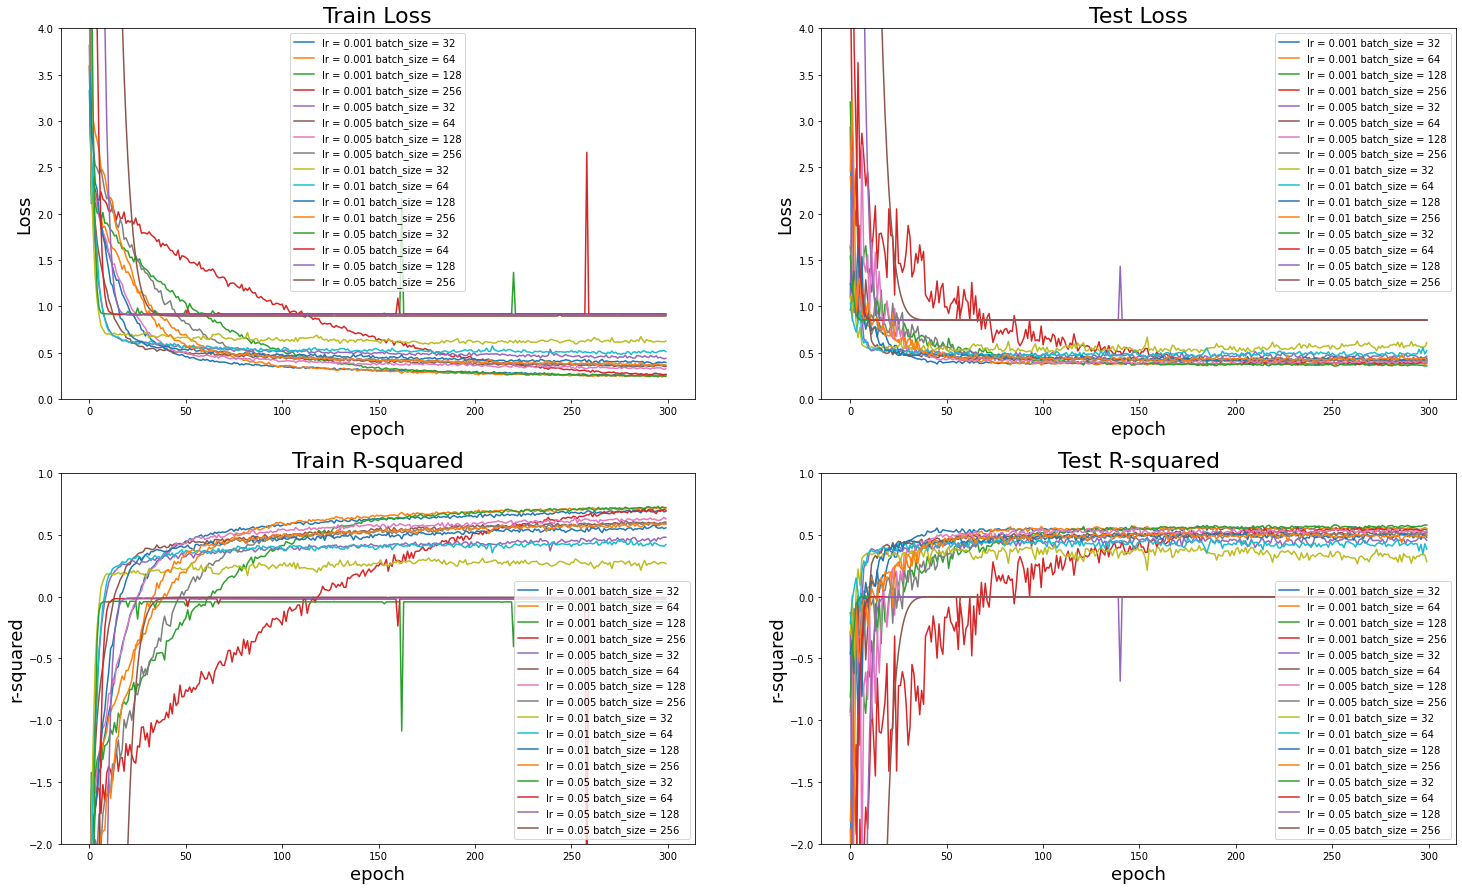

<Figure size 1800x1080 with 0 Axes>

In [15]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 4])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 4])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-2,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-2,1])

plt.show()

In [16]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   

0.6908036298825209
0.7146145130718007
0.721648340986998
0.6997428402603398
0.4808412872367032
0.6044766880646261
0.630702892545216
0.5899095029669472
0.2688679039351919
0.4220851797004589
0.5578335047540479
0.5894018988037406
-0.041789205897369126
-0.01869979991517301
-0.010979471877464501
-0.004840962958095485
___________________

0.5397657796096371
0.5510502511521611
0.5797923198582791
0.5199681866613727
0.4569166689499471
0.5185717730245131
0.5265812412481589
0.49764569713418016
0.2831001414793852
0.3855154337600085
0.4814215944859257
0.502209026760517
-0.0024772558819137203
-0.00014401999835755852
-0.0018018856245494153
-0.0001393066848578428
___________________

0.25962129005035106
0.24955427710317138
0.24443610214580924
0.26789580335219704
0.43980218687538425
0.3513062796913661
0.3274261119254565
0.3624529192845027
0.6257162935744027
0.512220715228309
0.3947714222437244
0.36484054376681646
0.9196295978045771
0.9154056408721157
0.9075771744473505
0.8957458714644114
_______________

### 2 best models

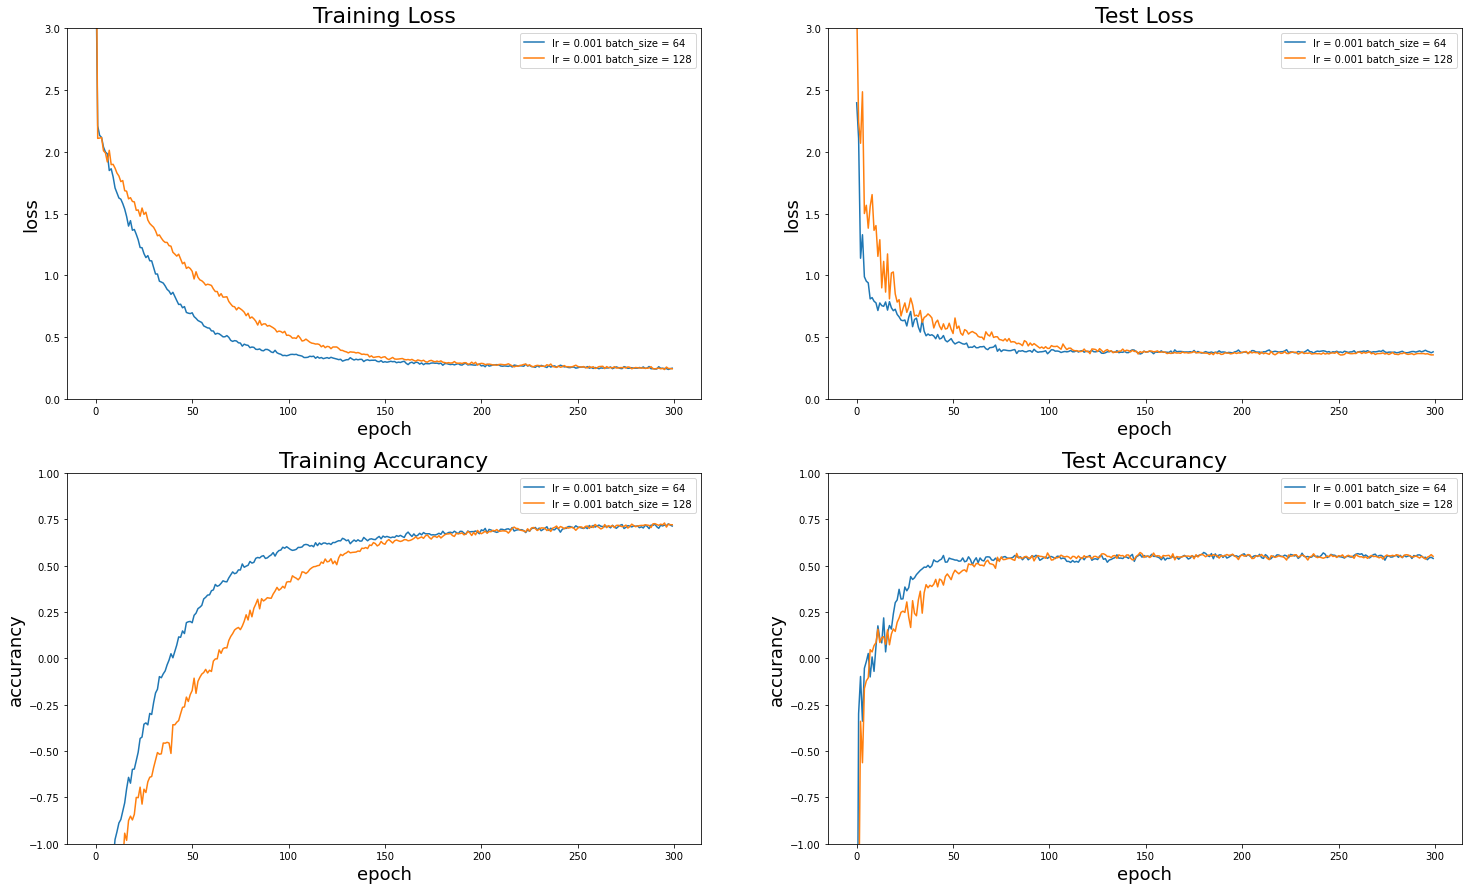

<Figure size 432x288 with 0 Axes>

In [19]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Training Loss", fontsize=22)
ax1.plot(train_losses_all[1],label="lr = 0.001 batch_size = 64")
ax1.plot(train_losses_all[2],label="lr = 0.001 batch_size = 128")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 3])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[1],label="lr = 0.001 batch_size = 64")
ax2.plot(test_losses_all[2],label="lr = 0.001 batch_size = 128")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 3])

ax3.set_title("Training Accurancy", fontsize=22)
ax3.plot(train_accs_all[1],label="lr = 0.001 batch_size = 64")
ax3.plot(train_accs_all[2],label="lr = 0.001 batch_size = 128")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-1,1])

ax4.set_title("Test Accurancy", fontsize=22)
ax4.plot(test_accs_all[0],label="lr = 0.001 batch_size = 64")
ax4.plot(test_accs_all[1],label="lr = 0.001 batch_size = 128")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-1,1])
plt.show()

## 4.2. Training

In [20]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=2127, shuffle=False)

In [21]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/cardio_maccs_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 4.11372848055256, Accuracy: -3.7044624285092915
Test Avg. loss: 3.6344144344329834, Accuracy: -3.0588566375621022
################## EPOCH 2 ##################
Train Avg. loss: 2.233950056246857, Accuracy: -1.5331223765261555
Test Avg. loss: 2.8593764305114746, Accuracy: -2.193306243922908
################## EPOCH 3 ##################
Train Avg. loss: 2.232684542883688, Accuracy: -1.531094338968452
Test Avg. loss: 2.321077823638916, Accuracy: -1.5921433754542007
################## EPOCH 4 ##################
Train Avg. loss: 2.109778039490999, Accuracy: -1.387068642105872
Test Avg. loss: 2.8951051235198975, Accuracy: -2.2332077418136858
################## EPOCH 5 ##################
Train Avg. loss: 2.1366268947942935, Accuracy: -1.4262688239392551
Test Avg. loss: 1.461267113685608, Accuracy: -0.6319201744804732
################## EPOCH 6 ##################
Train Avg. loss: 2.0074364925498394, Accuracy: -1.2707547159469947
Te

Train Avg. loss: 1.0466496295003749, Accuracy: -0.18268475955243796
Test Avg. loss: 0.7628035545349121, Accuracy: 0.14811305161757748
################## EPOCH 48 ##################
Train Avg. loss: 0.9942918233017424, Accuracy: -0.1310262224032821
Test Avg. loss: 0.6625458598136902, Accuracy: 0.2600792393473198
################## EPOCH 49 ##################
Train Avg. loss: 1.009715680755786, Accuracy: -0.14065650694560122
Test Avg. loss: 0.6692545413970947, Accuracy: 0.2525870766926098
################## EPOCH 50 ##################
Train Avg. loss: 0.9706097102876919, Accuracy: -0.09645744407310525
Test Avg. loss: 0.730212390422821, Accuracy: 0.18451033448373377
################## EPOCH 51 ##################
Train Avg. loss: 0.9441212389006544, Accuracy: -0.06223775513101247
Test Avg. loss: 0.644040584564209, Accuracy: 0.280745657877957
################## EPOCH 52 ##################
Train Avg. loss: 0.9316483887273874, Accuracy: -0.05208203802892849
Test Avg. loss: 0.6804238557815552,

Train Avg. loss: 0.500432342735689, Accuracy: 0.4359254202444251
Test Avg. loss: 0.44601118564605713, Accuracy: 0.501901783614547
################## EPOCH 94 ##################
Train Avg. loss: 0.4938090977384083, Accuracy: 0.4433158090023713
Test Avg. loss: 0.42718422412872314, Accuracy: 0.522927418273732
################## EPOCH 95 ##################
Train Avg. loss: 0.49615659598094314, Accuracy: 0.440858265924025
Test Avg. loss: 0.45215296745300293, Accuracy: 0.4950426968723862
################## EPOCH 96 ##################
Train Avg. loss: 0.4799542209105705, Accuracy: 0.46015477681007055
Test Avg. loss: 0.4327939748764038, Accuracy: 0.5166625128037392
################## EPOCH 97 ##################
Train Avg. loss: 0.47293269278398203, Accuracy: 0.4686091284469185
Test Avg. loss: 0.42886117100715637, Accuracy: 0.5210546263347098
################## EPOCH 98 ##################
Train Avg. loss: 0.4733788144232622, Accuracy: 0.46893216299180274
Test Avg. loss: 0.43144920468330383, Acc

Train Avg. loss: 0.33146345771070734, Accuracy: 0.6273584244053225
Test Avg. loss: 0.39206361770629883, Accuracy: 0.5621495288988922
################## EPOCH 140 ##################
Train Avg. loss: 0.3317808533337579, Accuracy: 0.6279465183036079
Test Avg. loss: 0.3824745714664459, Accuracy: 0.5728584374026296
################## EPOCH 141 ##################
Train Avg. loss: 0.31721170446765956, Accuracy: 0.6441831161635956
Test Avg. loss: 0.38443392515182495, Accuracy: 0.5706702448823697
################## EPOCH 142 ##################
Train Avg. loss: 0.30983484169440484, Accuracy: 0.6519255213523016
Test Avg. loss: 0.3842450976371765, Accuracy: 0.5708811213043892
################## EPOCH 143 ##################
Train Avg. loss: 0.31724624358006376, Accuracy: 0.6445415859711131
Test Avg. loss: 0.3877566456794739, Accuracy: 0.5669595111254611
################## EPOCH 144 ##################
Train Avg. loss: 0.32682867125788734, Accuracy: 0.633986711271804
Test Avg. loss: 0.386590898036956

Train Avg. loss: 0.2849705793074708, Accuracy: 0.6809362501089575
Test Avg. loss: 0.38750267028808594, Accuracy: 0.5672431471411705
################## EPOCH 186 ##################
Train Avg. loss: 0.28933481872081757, Accuracy: 0.6779097676460656
Test Avg. loss: 0.38154998421669006, Accuracy: 0.5738909880688519
################## EPOCH 187 ##################
Train Avg. loss: 0.2713343652326669, Accuracy: 0.6952199573162872
Test Avg. loss: 0.38122880458831787, Accuracy: 0.5742496647041282
################## EPOCH 188 ##################
Train Avg. loss: 0.2755055271867496, Accuracy: 0.6912747942068479
Test Avg. loss: 0.3803737461566925, Accuracy: 0.5752045946929323
################## EPOCH 189 ##################
Train Avg. loss: 0.2795328035283445, Accuracy: 0.6876842767848043
Test Avg. loss: 0.37615087628364563, Accuracy: 0.5799206896837432
################## EPOCH 190 ##################
Train Avg. loss: 0.2752564195821534, Accuracy: 0.6913464178108226
Test Avg. loss: 0.3813707530498504

Train Avg. loss: 0.26356229586387747, Accuracy: 0.703072423328868
Test Avg. loss: 0.3819333612918854, Accuracy: 0.5734628526401276
################## EPOCH 232 ##################
Train Avg. loss: 0.2656343872867413, Accuracy: 0.7012074665888459
Test Avg. loss: 0.37095946073532104, Accuracy: 0.5857183074831219
################## EPOCH 233 ##################
Train Avg. loss: 0.26652010341188803, Accuracy: 0.7011390938280598
Test Avg. loss: 0.38402441143989563, Accuracy: 0.5711276247694759
################## EPOCH 234 ##################
Train Avg. loss: 0.2612775537505079, Accuracy: 0.7060559631017257
Test Avg. loss: 0.38061028718948364, Accuracy: 0.574940458441702
################## EPOCH 235 ##################
Train Avg. loss: 0.2560844768339129, Accuracy: 0.7121786479968919
Test Avg. loss: 0.3808453679084778, Accuracy: 0.5746779080917332
################## EPOCH 236 ##################
Train Avg. loss: 0.2537766396999359, Accuracy: 0.7140766083928265
Test Avg. loss: 0.3794768452644348, 

Train Avg. loss: 0.24567814104592622, Accuracy: 0.724361432302186
Test Avg. loss: 0.3768307864665985, Accuracy: 0.579161320236111
################## EPOCH 278 ##################
Train Avg. loss: 0.23745064859959616, Accuracy: 0.7327066591869227
Test Avg. loss: 0.3808133006095886, Accuracy: 0.5747137474450894
################## EPOCH 279 ##################
Train Avg. loss: 0.23586638004922156, Accuracy: 0.7348223897534067
Test Avg. loss: 0.3766283094882965, Accuracy: 0.5793874461573763
################## EPOCH 280 ##################
Train Avg. loss: 0.2394712458350765, Accuracy: 0.7305589953051501
Test Avg. loss: 0.3769601285457611, Accuracy: 0.5790168837439165
################## EPOCH 281 ##################
Train Avg. loss: 0.24094070783301966, Accuracy: 0.728951942807313
Test Avg. loss: 0.3781818151473999, Accuracy: 0.5776525229527913
################## EPOCH 282 ##################
Train Avg. loss: 0.2465303397890347, Accuracy: 0.7238097823944984
Test Avg. loss: 0.37806224822998047, A

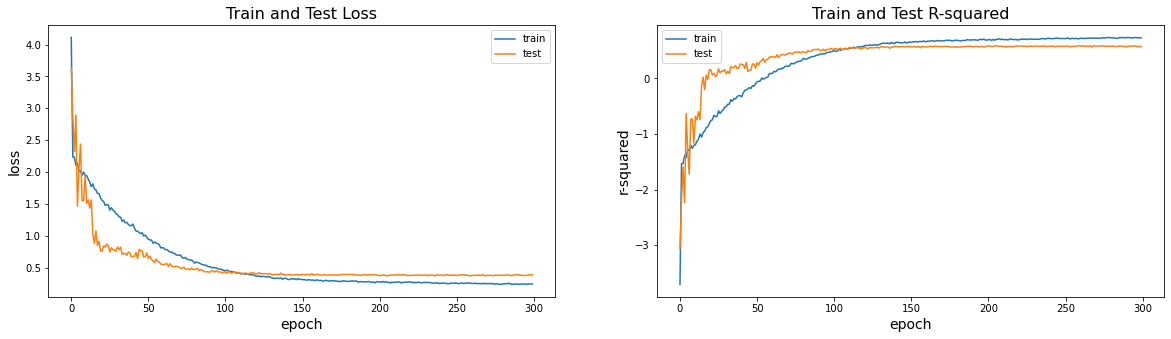

<Figure size 1440x360 with 0 Axes>

In [22]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.legend()

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.legend()
plt.show()

In [23]:
model = FCNN()
model.load_state_dict(torch.load('../../models/cardio_maccs_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 0.42747134
MSE: 0.36880502
RMSE: 0.6072932
R2 Square 0.588124362489244 

